In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [ ]:
import os
import json
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.callbacks import ModelCheckpoint, TensorBoard
import datetime

# ====================================
# 1) Mixed Precision & Basic Setup
# ====================================
tf.keras.mixed_precision.set_global_policy('mixed_float16')
print("Mixed precision enabled:", tf.keras.mixed_precision.global_policy())

# ====================================
# 2) CONFIGURATION & PATHS
# ====================================
image_dir = "/kaggle/input/trees-nineteen-dataset"
save_dir = "/kaggle/working"
os.makedirs(save_dir, exist_ok=True)

model_prefix = os.path.join(save_dir, "model_epoch_")
latest_model_path = os.path.join(save_dir, "latest_model.keras")
history_path = os.path.join(save_dir, "history.json")
class_indices_path = os.path.join(save_dir, "class_indices.json")
log_dir = os.path.join(save_dir, "logs", datetime.datetime.now().strftime("%Y%m%d-%H%M%S"))

weights_file = "/kaggle/input/efficientnetb3/efficientnetb3_notop.h5"
if not os.path.exists(weights_file):
    raise FileNotFoundError("Weights file not found! Please upload EfficientNetB3 weights.")
else:
    print("Using local weights file:", weights_file)

batch_size = 32
input_shape = (224, 224, 3)
initial_epochs = 3
fine_tune_epochs = 5
base_learning_rate = 0.0005
fine_tune_learning_rate = 1e-6

# ====================================
# 3) DETECT CLASSES & BUILD CLASS INDICES
# ====================================
detected_classes = sorted(
    d for d in os.listdir(image_dir) if os.path.isdir(os.path.join(image_dir, d))
)

if os.path.exists(class_indices_path):
    with open(class_indices_path, "r") as f:
        class_indices = json.load(f)
else:
    class_indices = {name: i for i, name in enumerate(detected_classes)}
    with open(class_indices_path, "w") as f:
        json.dump(class_indices, f)
num_classes = len(class_indices)
print("Class indices:", class_indices)

# ====================================
# 4) OPTIMIZED DATA LOADING USING `tf.data`
# ====================================
def preprocess_image(image, label):
    image = tf.image.resize(image, (224, 224))  # Resize to model input size
    image = tf.keras.applications.efficientnet.preprocess_input(image)  # Normalize [-1, 1]
    return image, label

def load_data(subset):
    datagen = tf.keras.preprocessing.image_dataset_from_directory(
        image_dir,
        image_size=(224, 224),
        batch_size=batch_size,
        validation_split=0.2,
        subset=subset,
        seed=42,
        label_mode='categorical'
    )
    return datagen.map(preprocess_image).cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)

train_dataset = load_data("training")
val_dataset = load_data("validation")

# ====================================
# 5) DEFINE MODEL CREATION FUNCTION
# ====================================
def create_model(fine_tune=False):
    base_model = keras.applications.EfficientNetB3(
        include_top=False,
        weights=weights_file,
        input_shape=input_shape
    )

    if fine_tune:
        base_model.trainable = True
        fine_tune_at = len(base_model.layers) - 50  # Unfreeze last 50 layers
        for layer in base_model.layers[:fine_tune_at]:
            layer.trainable = False
        learning_rate = fine_tune_learning_rate
    else:
        base_model.trainable = False
        learning_rate = base_learning_rate

    model = keras.Sequential([
        keras.Input(shape=input_shape),
        base_model,
        layers.GlobalAveragePooling2D(),
        layers.BatchNormalization(),
        layers.Dense(512, activation='relu'),
        layers.Dropout(0.5),
        layers.Dense(num_classes, activation='softmax', dtype='float32')
    ])

    optimizer = keras.optimizers.AdamW(learning_rate=learning_rate)
    model.compile(
        optimizer=optimizer,
        loss='categorical_crossentropy',
        metrics=['accuracy']
    )
    return model

# ====================================
# 6) LOAD OR CREATE MODEL
# ====================================
if os.path.exists(latest_model_path):
    model = keras.models.load_model(latest_model_path)
    print("✅ Loaded latest model from disk.")
else:
    model = create_model()
    print("🚀 Created new model from scratch.")

# ====================================
# 7) TRAINING FUNCTION WITH PER-EPOCH SAVING
# ====================================
def train_model(model, epochs, start_epoch=1):
    for epoch in range(start_epoch, start_epoch + epochs):
        print(f"\n🔄 Training epoch {epoch}/{start_epoch + epochs - 1}...")
        model.fit(train_dataset, validation_data=val_dataset, epochs=1)

        model_epoch_path = f"{model_prefix}{epoch}.keras"
        model.save(model_epoch_path)
        model.save(latest_model_path)
        print(f"✅ Model saved: {model_epoch_path}")

    print("✅ Training session complete!")

# ====================================
# 8) INITIAL TRAINING (SAVES EVERY EPOCH)
# ====================================
print("\n=== Initial Training Phase ===")
train_model(model, epochs=2)  # Run only 2 epochs per Kaggle session

# ====================================
# 9) HOW TO RESUME TRAINING NEXT TIME
# ====================================
# 1. Upload the latest saved model (e.g., model_epoch_2.keras) to Kaggle input.
# 2. Update 'latest_model_path' to point to the uploaded model.
# 3. Restart training from the next epoch.


In [ ]:
import os
import json
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau, TensorBoard
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import mixed_precision
import datetime

# ====================================
# 1) Mixed Precision & Basic Setup
# ====================================
mixed_precision.set_global_policy('mixed_float16')
print("Mixed precision enabled:", mixed_precision.global_policy())

# ====================================
# 2) CONFIGURATION & PATHS
# ====================================
image_dir = "/kaggle/input/trees-nineteen-dataset"
save_dir = "/kaggle/working"
os.makedirs(save_dir, exist_ok=True)

model_prefix = os.path.join(save_dir, "model_epoch_")
latest_model_path = os.path.join(save_dir, "latest_model.keras")
history_path = os.path.join(save_dir, "history.json")
class_indices_path = os.path.join(save_dir, "class_indices.json")
log_dir = os.path.join(save_dir, "logs", datetime.datetime.now().strftime("%Y%m%d-%H%M%S"))

weights_file = "/kaggle/input/efficientnetb3/efficientnetb3_notop.h5"
if not os.path.exists(weights_file):
    raise FileNotFoundError("Weights file not found! Please upload EfficientNetB3 weights.")
else:
    print("Using local weights file:", weights_file)

batch_size = 64
input_shape = (224, 224, 3)
initial_epochs = 3
fine_tune_epochs = 5
base_learning_rate = 0.0005
fine_tune_learning_rate = 1e-6

# ====================================
# 3) DETECT CLASSES & BUILD CLASS INDICES
# ====================================
detected_classes = sorted(
    d for d in os.listdir(image_dir) if os.path.isdir(os.path.join(image_dir, d))
)

if os.path.exists(class_indices_path):
    with open(class_indices_path, "r") as f:
        class_indices = json.load(f)
else:
    class_indices = {name: i for i, name in enumerate(detected_classes)}
    with open(class_indices_path, "w") as f:
        json.dump(class_indices, f)
num_classes = len(class_indices)
print("Class indices:", class_indices)

# ====================================
# 4) SET UP DATA GENERATORS
# ====================================
from tensorflow.keras.applications.efficientnet import preprocess_input

datagen = ImageDataGenerator(
    preprocessing_function=preprocess_input,  # Normalizes to [-1, 1]
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.3,
    horizontal_flip=True,
    brightness_range=[0.7, 1.3],
    fill_mode="nearest",
    validation_split=0.2
)

train_generator = datagen.flow_from_directory(
    directory=image_dir,
    target_size=input_shape[:2],
    batch_size=batch_size,
    class_mode='categorical',
    subset='training',
    shuffle=True,
    classes=list(class_indices.keys())
)

val_generator = datagen.flow_from_directory(
    directory=image_dir,
    target_size=input_shape[:2],
    batch_size=batch_size,
    class_mode='categorical',
    subset='validation',
    shuffle=False,
    classes=list(class_indices.keys())
)

# ====================================
# 5) DEFINE MODEL CREATION FUNCTION
# ====================================
def create_model(fine_tune=False):
    base_model = keras.applications.EfficientNetB3(
        include_top=False,
        weights=weights_file,
        input_shape=input_shape
    )

    if fine_tune:
        base_model.trainable = True
        fine_tune_at = len(base_model.layers) - 50  # Unfreeze last 50 layers
        for layer in base_model.layers[:fine_tune_at]:
            layer.trainable = False
        learning_rate = fine_tune_learning_rate
    else:
        base_model.trainable = False
        learning_rate = base_learning_rate

    model = keras.Sequential([
        keras.Input(shape=input_shape),
        base_model,
        layers.GlobalAveragePooling2D(),
        layers.BatchNormalization(),
        layers.Dense(512, activation='relu'),
        layers.Dropout(0.5),
        layers.Dense(num_classes, activation='softmax', dtype='float32')
    ])

    optimizer = keras.optimizers.AdamW(learning_rate=learning_rate)
    model.compile(
        optimizer=optimizer,
        loss='categorical_crossentropy',
        metrics=['accuracy']
    )
    return model

# ====================================
# 6) LOAD OR CREATE MODEL
# ====================================
if os.path.exists(latest_model_path):
    model = keras.models.load_model(latest_model_path)
    print("✅ Loaded latest model from disk.")
else:
    model = create_model()
    print("🚀 Created new model from scratch.")

# ====================================
# 7) TRAINING FUNCTION WITH PER-EPOCH SAVING
# ====================================
def train_model(model, epochs, start_epoch=1):
    for epoch in range(start_epoch, start_epoch + epochs):
        print(f"\n🔄 Training epoch {epoch}/{start_epoch + epochs - 1}...")
        model.fit(train_generator, validation_data=val_generator, epochs=1)
        
        model_epoch_path = f"{model_prefix}{epoch}.keras"
        model.save(model_epoch_path)
        model.save(latest_model_path)
        print(f"✅ Model saved: {model_epoch_path}")
        
    print("✅ Training session complete!")

# , start_epoch=3
# ====================================
# 8) INITIAL TRAINING (SAVES EVERY EPOCH)
# ====================================
print("\n=== Initial Training Phase ===")
train_model(model, epochs=2)  # Run only 2 epochs per Kaggle session

# ====================================
# 9) HOW TO RESUME TRAINING NEXT TIME
# ====================================
# 1. Upload the latest saved model (e.g., model_epoch_2.keras) to Kaggle input.
# 2. Update 'latest_model_path' to point to the uploaded model.
# 3. Restart training from the next epoch.


In [ ]:
import os
import json
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

# ====================================
# 1) Basic Setup & Paths
# ====================================
tf.keras.mixed_precision.set_global_policy('mixed_float16')
print("✅ Mixed precision enabled")

image_dir = "/kaggle/input/trees-nineteen-dataset"
weights_path = "/kaggle/input/efficientnetb3/efficientnetb3_notop.h5"  # Uploaded weights
save_dir = "/kaggle/working"
os.makedirs(save_dir, exist_ok=True)

latest_model_path = os.path.join(save_dir, "latest_model.keras")
class_indices_path = os.path.join(save_dir, "class_indices.json")

batch_size = 16  # ✅ Adjusted for better memory usage
input_shape = (224, 224, 3)
epochs = 3
learning_rate = 0.0005
fine_tune_layers = 50  # ✅ Unfreeze last 50 layers

# ====================================
# 2) Detect Classes
# ====================================
detected_classes = sorted(
    d for d in os.listdir(image_dir) if os.path.isdir(os.path.join(image_dir, d))
)

if os.path.exists(class_indices_path):
    with open(class_indices_path, "r") as f:
        class_indices = json.load(f)
else:
    class_indices = {name: i for i, name in enumerate(detected_classes)}
    with open(class_indices_path, "w") as f:
        json.dump(class_indices, f)
num_classes = len(class_indices)
print(f"📌 Detected {num_classes} classes")

# ====================================
# 3) Optimized Data Pipeline
# ====================================
def preprocess_image(image, label):
    image = tf.image.resize(image, (224, 224))
    image = tf.keras.applications.efficientnet.preprocess_input(image)
    return image, label

def load_data(subset):
    dataset = tf.keras.preprocessing.image_dataset_from_directory(
        image_dir,
        image_size=(224, 224),
        batch_size=batch_size,
        validation_split=0.2,
        subset=subset,
        seed=42,
        label_mode='categorical'
    )
    dataset = dataset.map(preprocess_image, num_parallel_calls=tf.data.AUTOTUNE)
    
    if subset == "training":
        dataset = dataset.prefetch(tf.data.AUTOTUNE)  # ✅ No `cache()` to save RAM
    else:
        dataset = dataset.cache().prefetch(tf.data.AUTOTUNE)  # ✅ Cache only validation

    return dataset

train_dataset = load_data("training")
val_dataset = load_data("validation")

# ====================================
# 4) Model Creation (Load Weights Manually)
# ====================================
def create_model():
    base_model = keras.applications.EfficientNetB3(
        include_top=False,
        weights=None,  # ✅ Avoids Kaggle download restrictions
        input_shape=input_shape
    )

    # ✅ Load weights from uploaded file
    if os.path.exists(weights_path):
        base_model.load_weights(weights_path)
        print("✅ Loaded EfficientNetB3 pretrained weights")
    else:
        print("⚠️ Warning: Pretrained weights not found! Using random initialization.")

    base_model.trainable = True
    for layer in base_model.layers[:-fine_tune_layers]:  
        layer.trainable = False  # ✅ Freeze early layers

    model = keras.Sequential([
        keras.Input(shape=input_shape),
        base_model,
        layers.MaxPooling2D(pool_size=(2, 2)),  # ✅ Saves memory
        layers.Flatten(),
        layers.Dense(512, activation='relu'),
        layers.Dropout(0.4),
        layers.Dense(num_classes, activation='softmax', dtype='float32')
    ])

    optimizer = keras.optimizers.AdamW(learning_rate=learning_rate)
    model.compile(optimizer=optimizer, loss="categorical_crossentropy", metrics=["accuracy"])
    return model

# ====================================
# 5) Load or Create Model
# ====================================
if os.path.exists(latest_model_path):
    model = keras.models.load_model(latest_model_path)
    print("✅ Loaded latest model")
else:
    model = create_model()
    print("🚀 Created new model with pretrained EfficientNetB3 weights")

# ====================================
# 6) Training with Memory Fix
# ====================================
model.fit(train_dataset, validation_data=val_dataset, epochs=epochs)
model.save(latest_model_path)
print("✅ Model saved!")


In [ ]:
import os
import json
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau, TensorBoard
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import mixed_precision
import datetime

# ====================================
# 1) Mixed Precision & Basic Setup
# ====================================
mixed_precision.set_global_policy('mixed_float16')
tf.config.optimizer.set_jit(True)  # Enable XLA compilation for faster training
print("Mixed precision enabled:", mixed_precision.global_policy())

# ====================================
# 2) CONFIGURATION & PATHS
# ====================================
image_dir = "/kaggle/input/trees-nineteen-dataset"
save_dir = "/kaggle/working"
os.makedirs(save_dir, exist_ok=True)

model_prefix = os.path.join(save_dir, "model_epoch_")
latest_model_path = os.path.join(save_dir, "latest_model.keras")
history_path = os.path.join(save_dir, "history.json")
class_indices_path = os.path.join(save_dir, "class_indices.json")
log_dir = os.path.join(save_dir, "logs", datetime.datetime.now().strftime("%Y%m%d-%H%M%S"))

weights_file = "/kaggle/input/efficientnetb3/efficientnetb3_notop.h5"
if not os.path.exists(weights_file):
    raise FileNotFoundError("Weights file not found! Please upload EfficientNetB3 weights.")
else:
    print("Using local weights file:", weights_file)

# Reduce batch size to prevent RAM issues
batch_size = 16  # Reduced from 32 to avoid out-of-memory errors
input_shape = (224, 224, 3)
initial_epochs = 3
fine_tune_epochs = 5
base_learning_rate = 0.0005
fine_tune_learning_rate = 1e-6

# ====================================
# 3) DETECT CLASSES & BUILD CLASS INDICES
# ====================================
detected_classes = sorted(
    d for d in os.listdir(image_dir) if os.path.isdir(os.path.join(image_dir, d))
)

if os.path.exists(class_indices_path):
    with open(class_indices_path, "r") as f:
        class_indices = json.load(f)
else:
    class_indices = {name: i for i, name in enumerate(detected_classes)}
    with open(class_indices_path, "w") as f:
        json.dump(class_indices, f)
num_classes = len(class_indices)
print("Class indices:", class_indices)

# ====================================
# 4) SET UP DATA GENERATORS (OPTIMIZED)
# ====================================
from tensorflow.keras.applications.efficientnet import preprocess_input

AUTOTUNE = tf.data.AUTOTUNE  # Optimize data loading

datagen = ImageDataGenerator(
    preprocessing_function=preprocess_input,  # Normalizes to [-1, 1]
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.3,
    horizontal_flip=True,
    brightness_range=[0.7, 1.3],
    fill_mode="nearest",
    validation_split=0.2
)

train_generator = datagen.flow_from_directory(
    directory=image_dir,
    target_size=input_shape[:2],
    batch_size=batch_size,
    class_mode='categorical',
    subset='training',
    shuffle=True,
    classes=list(class_indices.keys()),
    workers=2,  # Use 2 workers for faster data loading
    use_multiprocessing=True  # Enable multiprocessing
)

val_generator = datagen.flow_from_directory(
    directory=image_dir,
    target_size=input_shape[:2],
    batch_size=batch_size,
    class_mode='categorical',
    subset='validation',
    shuffle=False,
    classes=list(class_indices.keys()),
    workers=2,
    use_multiprocessing=True
)

# Prefetch data for better performance
train_dataset = tf.data.Dataset.from_generator(
    lambda: train_generator,
    output_signature=(
        tf.TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32),
        tf.TensorSpec(shape=(None, num_classes), dtype=tf.float32),
    )
).prefetch(buffer_size=AUTOTUNE)

val_dataset = tf.data.Dataset.from_generator(
    lambda: val_generator,
    output_signature=(
        tf.TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32),
        tf.TensorSpec(shape=(None, num_classes), dtype=tf.float32),
    )
).prefetch(buffer_size=AUTOTUNE)

# ====================================
# 5) DEFINE MODEL CREATION FUNCTION (OPTIMIZED)
# ====================================
def create_model(fine_tune=False):
    base_model = keras.applications.EfficientNetB3(
        include_top=False,
        weights=weights_file,
        input_shape=input_shape
    )

    if fine_tune:
        base_model.trainable = True
        fine_tune_at = len(base_model.layers) - 20  # Unfreeze last 20 layers (not 50)
        for layer in base_model.layers[:fine_tune_at]:
            layer.trainable = False
        learning_rate = fine_tune_learning_rate
    else:
        base_model.trainable = False
        learning_rate = base_learning_rate

    model = keras.Sequential([
        keras.Input(shape=input_shape),
        base_model,
        layers.GlobalAveragePooling2D(),
        layers.BatchNormalization(),
        layers.Dense(512, activation='relu'),
        layers.Dropout(0.5),
        layers.Dense(num_classes, activation='softmax', dtype='float32')
    ])

    optimizer = keras.optimizers.AdamW(learning_rate=learning_rate)
    model.compile(
        optimizer=optimizer,
        loss='categorical_crossentropy',
        metrics=['accuracy']
    )
    return model

# ====================================
# 6) LOAD OR CREATE MODEL
# ====================================
if os.path.exists(latest_model_path):
    model = keras.models.load_model(latest_model_path)
    print("✅ Loaded latest model from disk.")
else:
    model = create_model()
    print("🚀 Created new model from scratch.")

# ====================================
# 7) TRAINING FUNCTION WITH PER-EPOCH SAVING (OPTIMIZED)
# ====================================
def train_model(model, epochs, start_epoch=1):
    for epoch in range(start_epoch, start_epoch + epochs):
        print(f"\n🔄 Training epoch {epoch}/{start_epoch + epochs - 1}...")
        model.fit(train_dataset, validation_data=val_dataset, epochs=1)
        
        model_epoch_path = f"{model_prefix}{epoch}.keras"
        model.save(model_epoch_path)
        model.save(latest_model_path)
        print(f"✅ Model saved: {model_epoch_path}")
        
    print("✅ Training session complete!")

# ====================================
# 8) INITIAL TRAINING (SAVES EVERY EPOCH)
# ====================================
print("\n=== Initial Training Phase ===")
train_model(model, epochs=2)  # Run only 2 epochs per Kaggle session

# ====================================
# 9) HOW TO RESUME TRAINING NEXT TIME
# ====================================
# 1. Upload the latest saved model (e.g., model_epoch_2.keras) to Kaggle input.
# 2. Update 'latest_model_path' to point to the uploaded model.
# 3. Restart training from the next epoch.


In [ ]:
import os
import json
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau, TensorBoard
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import mixed_precision
import datetime

# ====================================
# 1) Mixed Precision & Basic Setup
# ====================================
mixed_precision.set_global_policy('mixed_float16')
print("Mixed precision enabled:", mixed_precision.global_policy())

# ====================================
# 2) CONFIGURATION & PATHS
# ====================================
image_dir = "/kaggle/input/trees-nineteen-dataset"
save_dir = "/kaggle/working"
os.makedirs(save_dir, exist_ok=True)

model_prefix = os.path.join(save_dir, "model_epoch_")
latest_model_path = os.path.join(save_dir, "latest_model.keras")
history_path = os.path.join(save_dir, "history.json")
class_indices_path = os.path.join(save_dir, "class_indices.json")
log_dir = os.path.join(save_dir, "logs", datetime.datetime.now().strftime("%Y%m%d-%H%M%S"))

weights_file = "/kaggle/input/efficientnetb3/efficientnetb3_notop.h5"
if not os.path.exists(weights_file):
    raise FileNotFoundError("Weights file not found! Please upload EfficientNetB3 weights.")
else:
    print("Using local weights file:", weights_file)

batch_size = 32
input_shape = (224, 224, 3)
initial_epochs = 3
fine_tune_epochs = 5
base_learning_rate = 0.0005
fine_tune_learning_rate = 1e-6

# ====================================
# 3) DETECT CLASSES & BUILD CLASS INDICES
# ====================================
detected_classes = sorted(
    d for d in os.listdir(image_dir) if os.path.isdir(os.path.join(image_dir, d))
)

if os.path.exists(class_indices_path):
    with open(class_indices_path, "r") as f:
        class_indices = json.load(f)
else:
    class_indices = {name: i for i, name in enumerate(detected_classes)}
    with open(class_indices_path, "w") as f:
        json.dump(class_indices, f)
num_classes = len(class_indices)
print("Class indices:", class_indices)

# ====================================
# 4) SET UP DATA GENERATORS
# ====================================
from tensorflow.keras.applications.efficientnet import preprocess_input

datagen = ImageDataGenerator(
    preprocessing_function=preprocess_input,  # Normalizes to [-1, 1]
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.3,
    horizontal_flip=True,
    brightness_range=[0.7, 1.3],
    fill_mode="nearest",
    validation_split=0.2
)

train_generator = datagen.flow_from_directory(
    directory=image_dir,
    target_size=input_shape[:2],
    batch_size=batch_size,
    class_mode='categorical',
    subset='training',
    shuffle=True,
    classes=list(class_indices.keys())  # Keep class order consistent
)

val_generator = datagen.flow_from_directory(
    directory=image_dir,
    target_size=input_shape[:2],
    batch_size=batch_size,
    class_mode='categorical',
    subset='validation',
    shuffle=False,
    classes=list(class_indices.keys())
)

# ====================================
# 5) DEFINE MODEL CREATION FUNCTION
# ====================================
def create_model(fine_tune=False):
    base_model = keras.applications.EfficientNetB3(
        include_top=False,
        weights=weights_file,
        input_shape=input_shape
    )

    if fine_tune:
        base_model.trainable = True
        fine_tune_at = len(base_model.layers) - 50  # Unfreeze last 50 layers
        for layer in base_model.layers[:fine_tune_at]:
            layer.trainable = False
        learning_rate = fine_tune_learning_rate
    else:
        base_model.trainable = False
        learning_rate = base_learning_rate

    model = keras.Sequential([
        keras.Input(shape=input_shape),
        base_model,
        layers.GlobalAveragePooling2D(),
        layers.BatchNormalization(),
        layers.Dense(512, activation='relu'),
        layers.Dropout(0.5),
        layers.Dense(num_classes, activation='softmax', dtype='float32')
    ])

    optimizer = keras.optimizers.AdamW(learning_rate=learning_rate)
    model.compile(
        optimizer=optimizer,
        loss='categorical_crossentropy',
        metrics=['accuracy']
    )
    return model

# ====================================
# 6) LOAD OR CREATE MODEL
# ====================================
if os.path.exists(latest_model_path):
    model = keras.models.load_model(latest_model_path)
    print("✅ Loaded latest model from disk.")
else:
    model = create_model()
    print("🚀 Created new model from scratch.")

# ====================================
# 7) TRAINING FUNCTION WITH PER-EPOCH SAVING
# ====================================
def train_model(model, epochs, start_epoch=1):
    for epoch in range(start_epoch, start_epoch + epochs):
        print(f"\n🔄 Training epoch {epoch}/{start_epoch + epochs - 1}...")
        model.fit(
            train_generator,
            validation_data=val_generator,
            epochs=1,
            workers=2,  # Multi-threaded data loading
            use_multiprocessing=True  # Reduce RAM usage
        )
        
        model_epoch_path = f"{model_prefix}{epoch}.keras"
        model.save(model_epoch_path)
        model.save(latest_model_path)
        print(f"✅ Model saved: {model_epoch_path}")
        
    print("✅ Training session complete!")

# ====================================
# 8) INITIAL TRAINING (SAVES EVERY EPOCH)
# ====================================
print("\n=== Initial Training Phase ===")
train_model(model, epochs=2)  # Run only 2 epochs per Kaggle session

# ====================================
# 9) HOW TO RESUME TRAINING NEXT TIME
# ====================================
# 1. Upload the latest saved model (e.g., model_epoch_2.keras) to Kaggle input.
# 2. Update 'latest_model_path' to point to the uploaded model.
# 3. Restart training from the next epoch.


In [ ]:
import os
import json
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau, TensorBoard
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import mixed_precision
import datetime

# ====================================
# 1) Mixed Precision & Basic Setup
# ====================================
mixed_precision.set_global_policy('mixed_float16')
print("Mixed precision enabled:", mixed_precision.global_policy())

# ====================================
# 2) CONFIGURATION & PATHS
# ====================================
image_dir = "/kaggle/input/trees-nineteen-dataset"
save_dir = "/kaggle/working"
os.makedirs(save_dir, exist_ok=True)

model_prefix = os.path.join(save_dir, "model_epoch_")
latest_model_path = os.path.join(save_dir, "latest_model.keras")
history_path = os.path.join(save_dir, "history.json")
class_indices_path = os.path.join(save_dir, "class_indices.json")
log_dir = os.path.join(save_dir, "logs", datetime.datetime.now().strftime("%Y%m%d-%H%M%S"))

weights_file = "/kaggle/input/efficientnetb3/efficientnetb3_notop.h5"
if not os.path.exists(weights_file):
    raise FileNotFoundError("Weights file not found! Please upload EfficientNetB3 weights.")
else:
    print("Using local weights file:", weights_file)

batch_size = 32
input_shape = (224, 224, 3)
initial_epochs = 3
fine_tune_epochs = 5
base_learning_rate = 0.0005
fine_tune_learning_rate = 1e-6

# ====================================
# 3) DETECT CLASSES & BUILD CLASS INDICES
# ====================================
detected_classes = sorted(
    d for d in os.listdir(image_dir) if os.path.isdir(os.path.join(image_dir, d))
)

if os.path.exists(class_indices_path):
    with open(class_indices_path, "r") as f:
        class_indices = json.load(f)
else:
    class_indices = {name: i for i, name in enumerate(detected_classes)}
    with open(class_indices_path, "w") as f:
        json.dump(class_indices, f)
num_classes = len(class_indices)
print("Class indices:", class_indices)

# ====================================
# 4) SET UP DATA GENERATORS
# ====================================
from tensorflow.keras.applications.efficientnet import preprocess_input

datagen = ImageDataGenerator(
    preprocessing_function=preprocess_input,  # Normalizes to [-1, 1]
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.3,
    horizontal_flip=True,
    brightness_range=[0.7, 1.3],
    fill_mode="nearest",
    validation_split=0.2
)

train_generator = datagen.flow_from_directory(
    directory=image_dir,
    target_size=input_shape[:2],
    batch_size=batch_size,
    class_mode='categorical',
    subset='training',
    shuffle=True,
    classes=list(class_indices.keys())  # Keep class order consistent
)

val_generator = datagen.flow_from_directory(
    directory=image_dir,
    target_size=input_shape[:2],
    batch_size=batch_size,
    class_mode='categorical',
    subset='validation',
    shuffle=False,
    classes=list(class_indices.keys())
)

steps_per_epoch = len(train_generator)  # Ensures controlled training on large datasets
validation_steps = len(val_generator)

# ====================================
# 5) DEFINE MODEL CREATION FUNCTION
# ====================================
def create_model(fine_tune=False):
    base_model = keras.applications.EfficientNetB3(
        include_top=False,
        weights=weights_file,
        input_shape=input_shape
    )

    if fine_tune:
        base_model.trainable = True
        fine_tune_at = len(base_model.layers) - 50  # Unfreeze last 50 layers
        for layer in base_model.layers[:fine_tune_at]:
            layer.trainable = False
        learning_rate = fine_tune_learning_rate
    else:
        base_model.trainable = False
        learning_rate = base_learning_rate

    model = keras.Sequential([
        keras.Input(shape=input_shape),
        base_model,
        layers.GlobalAveragePooling2D(),
        layers.BatchNormalization(),
        layers.Dense(512, activation='relu'),
        layers.Dropout(0.5),
        layers.Dense(num_classes, activation='softmax', dtype='float32')
    ])

    optimizer = keras.optimizers.AdamW(learning_rate=learning_rate)
    model.compile(
        optimizer=optimizer,
        loss='categorical_crossentropy',
        metrics=['accuracy']
    )
    return model

# ====================================
# 6) LOAD OR CREATE MODEL
# ====================================
if os.path.exists(latest_model_path):
    model = keras.models.load_model(latest_model_path)
    print("✅ Loaded latest model from disk.")
else:
    model = create_model()
    print("🚀 Created new model from scratch.")

# ====================================
# 7) TRAINING FUNCTION WITH PER-EPOCH SAVING
# ====================================
def train_model(model, epochs, start_epoch=1):
    for epoch in range(start_epoch, start_epoch + epochs):
        print(f"\n🔄 Training epoch {epoch}/{start_epoch + epochs - 1}...")
        model.fit(
            train_generator,
            validation_data=val_generator,
            epochs=1,
            steps_per_epoch=steps_per_epoch,
            validation_steps=validation_steps
        )
        
        model_epoch_path = f"{model_prefix}{epoch}.keras"
        model.save(model_epoch_path)
        model.save(latest_model_path)
        print(f"✅ Model saved: {model_epoch_path}")
        
    print("✅ Training session complete!")

# ====================================
# 8) INITIAL TRAINING (SAVES EVERY EPOCH)
# ====================================
print("\n=== Initial Training Phase ===")
train_model(model, epochs=2)  # Run only 2 epochs per Kaggle session

# ====================================
# 9) HOW TO RESUME TRAINING NEXT TIME
# ====================================
# 1. Upload the latest saved model (e.g., model_epoch_2.keras) to Kaggle input.
# 2. Update 'latest_model_path' to point to the uploaded model.
# 3. Restart training from the next epoch.


In [ ]:
import tensorflow as tf
import os
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import EfficientNetB3
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.mixed_precision import set_global_policy

# Enable mixed precision for GPU acceleration
try:
    set_global_policy('mixed_float16')  # Remove this if using CPU
except:
    print("Mixed precision not available, using default float32.")

# Paths & parameters
image_dir = "/kaggle/input/trees-nineteen-dataset"
batch_size = 16  # Reduced to optimize RAM usage
input_shape = (300, 300, 3)  # Ensure resolution remains unchanged
num_classes = 27

# Load EfficientNetB3 without top layers
base_model = EfficientNetB3(weights='/kaggle/input/efficientnetb3/efficientnetb3_notop.h5', 
                            include_top=False, input_shape=input_shape)

# Freeze base model layers
base_model.trainable = False

# Add custom classification head
x = GlobalAveragePooling2D()(base_model.output)
x = Dropout(0.4)(x)
x = Dense(512, activation='relu')(x)
x = Dropout(0.3)(x)
output = Dense(num_classes, activation='softmax', dtype='float32')(x)  # Ensure correct dtype

model = Model(inputs=base_model.input, outputs=output)

# Compile model
model.compile(optimizer=Adam(learning_rate=0.0005),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

# Data augmentation & generators
datagen = ImageDataGenerator(rescale=1./255, validation_split=0.2)

train_generator = datagen.flow_from_directory(
    directory=image_dir,
    target_size=input_shape[:2],
    batch_size=batch_size,
    class_mode='categorical',
    subset='training',
    shuffle=False,  # Disable shuffle to reduce RAM usage
)

val_generator = datagen.flow_from_directory(
    directory=image_dir,
    target_size=input_shape[:2],
    batch_size=batch_size,
    class_mode='categorical',
    subset='validation',
    shuffle=False,
)

# Training function to continue training across sessions
def train_model(model, epochs=2, start_epoch=1):
    for epoch in range(start_epoch, start_epoch + epochs):
        print(f"\n🔄 Training epoch {epoch}/{start_epoch + epochs - 1}...")
        model.fit(
            train_generator,
            validation_data=val_generator,
            epochs=1,  # Train 1 epoch per run to prevent crashes
            verbose=1
        )
        model.save(f"/kaggle/working/tree_classifier_epoch_{epoch}.h5")  # Save after each epoch

# Start training
print("\n=== Initial Training Phase ===")
train_model(model, epochs=2)  # Adjust this to fit within Kaggle limits


In [ ]:
import os
import json
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau, TensorBoard
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import mixed_precision
import datetime

# ====================================
# 1) Mixed Precision & Basic Setup
# ====================================
mixed_precision.set_global_policy('mixed_float16')
print("Mixed precision enabled:", mixed_precision.global_policy())

# ====================================
# 2) CONFIGURATION & PATHS
# ====================================
image_dir = "/kaggle/input/trees-nineteen-dataset"
save_dir = "/kaggle/working"
os.makedirs(save_dir, exist_ok=True)

model_prefix = os.path.join(save_dir, "model_epoch_")
latest_model_path = os.path.join(save_dir, "latest_model.keras")
history_path = os.path.join(save_dir, "history.json")
class_indices_path = os.path.join(save_dir, "class_indices.json")
log_dir = os.path.join(save_dir, "logs", datetime.datetime.now().strftime("%Y%m%d-%H%M%S"))

weights_file = "/kaggle/input/efficientnetb3/efficientnetb3_notop.h5"
if not os.path.exists(weights_file):
    raise FileNotFoundError("Weights file not found! Please upload EfficientNetB3 weights.")
else:
    print("Using local weights file:", weights_file)

batch_size = 16
input_shape = (224, 224, 3)
initial_epochs = 3
fine_tune_epochs = 5
base_learning_rate = 0.0005
fine_tune_learning_rate = 1e-6

# ====================================
# 3) DETECT CLASSES & BUILD CLASS INDICES
# ====================================
detected_classes = sorted(
    d for d in os.listdir(image_dir) if os.path.isdir(os.path.join(image_dir, d))
)

if os.path.exists(class_indices_path):
    with open(class_indices_path, "r") as f:
        class_indices = json.load(f)
else:
    class_indices = {name: i for i, name in enumerate(detected_classes)}
    with open(class_indices_path, "w") as f:
        json.dump(class_indices, f)
num_classes = len(class_indices)
print("Class indices:", class_indices)

# ====================================
# 4) SET UP DATA GENERATORS
# ====================================
from tensorflow.keras.applications.efficientnet import preprocess_input

datagen = ImageDataGenerator(
    preprocessing_function=preprocess_input,  # Normalizes to [-1, 1]
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.3,
    horizontal_flip=True,
    brightness_range=[0.7, 1.3],
    fill_mode="nearest",
    validation_split=0.2
)

train_generator = datagen.flow_from_directory(
    directory=image_dir,
    target_size=input_shape[:2],
    batch_size=batch_size,
    class_mode='categorical',
    subset='training',
    shuffle=True,
    classes=list(class_indices.keys())
)

val_generator = datagen.flow_from_directory(
    directory=image_dir,
    target_size=input_shape[:2],
    batch_size=batch_size,
    class_mode='categorical',
    subset='validation',
    shuffle=False,
    classes=list(class_indices.keys())
)

# ====================================
# 5) DEFINE MODEL CREATION FUNCTION
# ====================================
def create_model(fine_tune=False):
    base_model = keras.applications.EfficientNetB3(
        include_top=False,
        weights=weights_file,
        input_shape=input_shape
    )

    if fine_tune:
        base_model.trainable = True
        fine_tune_at = len(base_model.layers) - 50  # Unfreeze last 50 layers
        for layer in base_model.layers[:fine_tune_at]:
            layer.trainable = False
        learning_rate = fine_tune_learning_rate
    else:
        base_model.trainable = False
        learning_rate = base_learning_rate

    model = keras.Sequential([
        keras.Input(shape=input_shape),
        base_model,
        layers.GlobalAveragePooling2D(),
        layers.BatchNormalization(),
        layers.Dense(512, activation='relu'),
        layers.Dropout(0.5),
        layers.Dense(num_classes, activation='softmax', dtype='float32')
    ])

    optimizer = keras.optimizers.AdamW(learning_rate=learning_rate)
    model.compile(
        optimizer=optimizer,
        loss='categorical_crossentropy',
        metrics=['accuracy']
    )
    return model

# ====================================
# 6) LOAD OR CREATE MODEL
# ====================================
if os.path.exists(latest_model_path):
    model = keras.models.load_model(latest_model_path)
    print("✅ Loaded latest model from disk.")
else:
    model = create_model()
    print("🚀 Created new model from scratch.")

# ====================================
# 7) TRAINING FUNCTION WITH PER-EPOCH SAVING
# ====================================
def train_model(model, epochs, start_epoch=1):
    for epoch in range(start_epoch, start_epoch + epochs):
        print(f"\n🔄 Training epoch {epoch}/{start_epoch + epochs - 1}...")
        model.fit(train_generator, validation_data=val_generator, epochs=1)
        
        model_epoch_path = f"{model_prefix}{epoch}.keras"
        model.save(model_epoch_path)
        model.save(latest_model_path)
        print(f"✅ Model saved: {model_epoch_path}")
        
    print("✅ Training session complete!")

# , start_epoch=3
# ====================================
# 8) INITIAL TRAINING (SAVES EVERY EPOCH)
# ====================================
print("\n=== Initial Training Phase ===")
train_model(model, epochs=2)  # Run only 2 epochs per Kaggle session

# ====================================
# 9) HOW TO RESUME TRAINING NEXT TIME
# ====================================
# 1. Upload the latest saved model (e.g., model_epoch_2.keras) to Kaggle input.
# 2. Update 'latest_model_path' to point to the uploaded model.
# 3. Restart training from the next epoch.


In [ ]:
import os
import json
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau, TensorBoard
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import mixed_precision
import datetime
import matplotlib.pyplot as plt

# ====================================
# 1) Mixed Precision & Basic Setup
# ====================================
mixed_precision.set_global_policy('mixed_float16')
print("Mixed precision enabled:", mixed_precision.global_policy())

# ====================================
# 2) CONFIGURATION & PATHS (Kaggle)
# ====================================
# Update these paths according to your Kaggle environment:
image_dir = "/kaggle/input/trees-nineteen-dataset"  # Dataset folder; each subfolder is a class.
save_dir = "/kaggle/working"                        # Model, history, and logs will be saved here.
os.makedirs(save_dir, exist_ok=True)

# We will save individual epoch models with a prefix and also keep a "latest" copy.
model_prefix = os.path.join(save_dir, "model_epoch_")
latest_model_path = os.path.join(save_dir, "latest_model.keras")
history_path = os.path.join(save_dir, "history.json")
class_indices_path = os.path.join(save_dir, "class_indices.json")
log_dir = os.path.join(save_dir, "logs", datetime.datetime.now().strftime("%Y%m%d-%H%M%S"))

# IMPORTANT: Set the path to your local downloaded weights file.
# Upload your EfficientNetB3 weights file (e.g. "efficientnetb3_notop.h5") to the Kaggle working directory.
weights_file = "//kaggle/input/efficientnetb3/efficientnetb3_notop.h5"
if not os.path.exists(weights_file):
    raise FileNotFoundError("Weights file not found! Please upload your EfficientNetB3 weights file to: " + weights_file)
else:
    print("Using local weights file:", weights_file)

# Basic training parameters
batch_size = 32         # You can try reducing this (e.g., to 16) if you need faster epochs.
input_shape = (224, 224, 3)
base_learning_rate = 0.0005
initial_epochs = 3       # Number of epochs per training session in the initial phase
fine_tune_epochs = 5     # Number of epochs per fine-tuning session

# ====================================
# 3) DETECT CLASSES & BUILD CLASS INDICES
# ====================================
# Automatically detect classes from subfolders
detected_classes = sorted(
    d for d in os.listdir(image_dir)
    if os.path.isdir(os.path.join(image_dir, d))
)

# If a class indices JSON exists, update it; otherwise, create a new mapping.
if os.path.exists(class_indices_path):
    with open(class_indices_path, "r") as f:
        saved_class_indices = json.load(f)
    # Add any new classes
    for new_class in detected_classes:
        if new_class not in saved_class_indices:
            saved_class_indices[new_class] = len(saved_class_indices)
    class_indices = saved_class_indices
else:
    class_indices = {name: i for i, name in enumerate(detected_classes)}
    with open(class_indices_path, "w") as f:
        json.dump(class_indices, f)
num_classes = len(class_indices)
print("Updated class indices:", class_indices)

# ====================================
# 4) SET UP DATA GENERATORS
# ====================================
# Use EfficientNet's preprocess_input to normalize inputs to [-1, 1]
from tensorflow.keras.applications.efficientnet import preprocess_input

datagen = ImageDataGenerator(
    preprocessing_function=preprocess_input,
    rotation_range=30,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.3,
    horizontal_flip=True,
    brightness_range=[0.7, 1.3],
    fill_mode="nearest",
    validation_split=0.2
)

train_generator = datagen.flow_from_directory(
    directory=image_dir,
    target_size=input_shape[:2],
    batch_size=batch_size,
    class_mode='categorical',
    subset='training',
    shuffle=True,
    classes=list(class_indices.keys())  # Fixes the class order
)

val_generator = datagen.flow_from_directory(
    directory=image_dir,
    target_size=input_shape[:2],
    batch_size=batch_size,
    class_mode='categorical',
    subset='validation',
    shuffle=False,
    classes=list(class_indices.keys())
)

# ====================================
# 5) DEFINE MODEL CREATION FUNCTION
# ====================================
def create_model(fine_tune=False):
    # Build the base using EfficientNetB3 with local weights
    base_model = keras.applications.EfficientNetB3(
        include_top=False,
        weights=weights_file,  # Use local weights
        input_shape=input_shape
    )
    if fine_tune:
        base_model.trainable = True
        # Unfreeze the last 30 layers; keep earlier layers frozen
        fine_tune_at = len(base_model.layers) - 30
        for layer in base_model.layers[:fine_tune_at]:
            layer.trainable = False
        learning_rate = 1e-5  # Lower learning rate for fine-tuning
    else:
        base_model.trainable = False
        learning_rate = base_learning_rate

    model = keras.Sequential([
        keras.Input(shape=input_shape),
        base_model,
        layers.GlobalAveragePooling2D(),
        layers.BatchNormalization(),
        layers.Dense(512, activation='relu'),
        layers.Dropout(0.5),
        # Explicitly output float32 for compatibility with mixed precision
        layers.Dense(num_classes, activation='softmax', dtype='float32')
    ])
    optimizer = keras.optimizers.AdamW(learning_rate=learning_rate)
    model.compile(
        optimizer=optimizer,
        loss='categorical_crossentropy',
        metrics=['accuracy']
    )
    return model

# ====================================
# 6) LOAD OR CREATE MODEL
# ====================================
if os.path.exists(latest_model_path):
    model = keras.models.load_model(latest_model_path)
    print("✅ Loaded latest model from disk.")
else:
    model = create_model()
    print("🚀 Created new model from scratch.")

# ====================================
# 7) DEFINE CALLBACKS
# ====================================
checkpoint_callback = ModelCheckpoint(
    model_path,
    save_weights_only=False,
    save_best_only=False,  # Save every epoch
    verbose=1
)
early_stop = EarlyStopping(
    patience=5,
    restore_best_weights=True,
    monitor='val_loss'
)
reduce_lr = ReduceLROnPlateau(
    factor=0.5,
    patience=2,
    min_lr=1e-6,
    verbose=1
)
tensorboard_callback = TensorBoard(log_dir=log_dir, histogram_freq=1)

callbacks = [checkpoint_callback, early_stop, reduce_lr, tensorboard_callback]

# ====================================
# 8) TRAINING FUNCTION (WITH PER-EPOCH SAVING)
# ====================================
def train_model(model, epochs=3, start_epoch=1):
    for epoch in range(start_epoch, start_epoch + epochs):
        print(f"\n🔄 Training epoch {epoch}/{start_epoch + epochs - 1}...")
        # Train for one epoch at a time
        model.fit(
            train_generator,
            validation_data=val_generator,
            epochs=epoch + 1,
            initial_epoch=epoch
        )
        # Save model after each epoch
        model_epoch_path = f"{model_prefix}{epoch}.keras"
        model.save(model_epoch_path)
        model.save(latest_model_path)
        print(f"✅ Model saved: {model_epoch_path}")
    print("✅ Training session complete!")

# ====================================
# 9) MAIN TRAINING LOOP (INITIAL PHASE)
# ====================================
print("\n=== Initial Training Phase ===")
while True:
    ans = input("Run another initial training session? (yes/no): ")
    if ans.strip().lower() == "yes":
        train_model(model, epochs=3)  # Run 3 epochs per session
    else:
        break

# ====================================
# 10) FINE-TUNING PHASE (Optional)
# ====================================
ans = input("Proceed to fine-tuning phase? (yes/no): ")
if ans.strip().lower() == "yes":
    ft_model = create_model(fine_tune=True)
    ft_model.load_weights(latest_model_path)
    print("🔄 Starting fine-tuning with last 30 layers unfrozen.")
    train_model(ft_model, epochs=5)  # Fine-tune for 5 epochs per session
    print("✅ Fine-tuning complete!")


In [ ]:
import os
import json
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau, TensorBoard
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import mixed_precision
import datetime

# Enable Mixed Precision & XLA for Speed Boost 🚀
mixed_precision.set_global_policy('mixed_float16')
tf.config.optimizer.set_jit(True)  # XLA Compilation

print("Mixed precision enabled:", mixed_precision.global_policy())

# ====================================
# 1) CONFIGURATION & PATHS
# ====================================
image_dir = "/kaggle/input/trees-nineteen-dataset"
save_dir = "/kaggle/working"
os.makedirs(save_dir, exist_ok=True)

model_prefix = os.path.join(save_dir, "model_epoch_")
latest_model_path = os.path.join(save_dir, "latest_model.keras")
history_path = os.path.join(save_dir, "history.json")
class_indices_path = os.path.join(save_dir, "class_indices.json")
log_dir = os.path.join(save_dir, "logs", datetime.datetime.now().strftime("%Y%m%d-%H%M%S"))

weights_file = "/kaggle/input/efficientnetb3/efficientnetb3_notop.h5"
if not os.path.exists(weights_file):
    raise FileNotFoundError("Weights file not found! Please upload EfficientNetB3 weights.")
else:
    print("Using local weights file:", weights_file)

# Hyperparameters (Optimized for Speed ⚡)
batch_size = 32  # Increased from 16 to 32
input_shape = (224, 224, 3)
initial_epochs = 2  # Reduce epochs per session
fine_tune_epochs = 3  # Fine-tune with fewer epochs
base_learning_rate = 0.0005
fine_tune_learning_rate = 1e-5

# ====================================
# 2) DETECT CLASSES & BUILD CLASS INDICES
# ====================================
detected_classes = sorted(
    d for d in os.listdir(image_dir) if os.path.isdir(os.path.join(image_dir, d))
)

if os.path.exists(class_indices_path):
    with open(class_indices_path, "r") as f:
        class_indices = json.load(f)
else:
    class_indices = {name: i for i, name in enumerate(detected_classes)}
    with open(class_indices_path, "w") as f:
        json.dump(class_indices, f)

num_classes = len(class_indices)
print("Class indices:", class_indices)

# ====================================
# 3) DATA GENERATORS (Optimized)
# ====================================
from tensorflow.keras.applications.efficientnet import preprocess_input

datagen = ImageDataGenerator(
    preprocessing_function=preprocess_input,  # EfficientNet built-in preprocessing
    rotation_range=20,  # Reduced for speed
    width_shift_range=0.1,
    height_shift_range=0.1,
    zoom_range=0.2,
    horizontal_flip=True,
    validation_split=0.2
)

train_generator = datagen.flow_from_directory(
    directory=image_dir,
    target_size=input_shape[:2],
    batch_size=batch_size,
    class_mode='categorical',
    subset='training',
    shuffle=True,
    classes=list(class_indices.keys())
)

val_generator = datagen.flow_from_directory(
    directory=image_dir,
    target_size=input_shape[:2],
    batch_size=batch_size,
    class_mode='categorical',
    subset='validation',
    shuffle=False,
    classes=list(class_indices.keys())
)

# ====================================
# 4) DEFINE MODEL CREATION FUNCTION
# ====================================
def create_model(fine_tune=False):
    base_model = keras.applications.EfficientNetB3(
        include_top=False,
        weights=weights_file,
        input_shape=input_shape
    )

    if fine_tune:
        base_model.trainable = True
        fine_tune_at = len(base_model.layers) - 50  # Unfreeze last 50 layers
        for layer in base_model.layers[:fine_tune_at]:
            layer.trainable = False
        learning_rate = fine_tune_learning_rate
    else:
        base_model.trainable = False
        learning_rate = base_learning_rate

    model = keras.Sequential([
        keras.Input(shape=input_shape),
        base_model,
        layers.GlobalAveragePooling2D(),
        layers.BatchNormalization(),
        layers.Dense(512, activation='relu'),
        layers.Dropout(0.3),  # Reduced dropout for speed
        layers.Dense(num_classes, activation='softmax', dtype='float32')
    ])

    optimizer = keras.optimizers.AdamW(learning_rate=learning_rate)
    model.compile(
        optimizer=optimizer,
        loss='categorical_crossentropy',
        metrics=['accuracy']
    )
    return model

# ====================================
# 5) LOAD OR CREATE MODEL
# ====================================
if os.path.exists(latest_model_path):
    model = keras.models.load_model(latest_model_path)
    print("✅ Loaded latest model from disk.")
else:
    model = create_model()
    print("🚀 Created new model from scratch.")

# ====================================
# 6) CALLBACKS FOR FASTER TRAINING
# ====================================
checkpoint_callback = ModelCheckpoint(
    latest_model_path,  # Save latest model
    save_weights_only=False,
    save_best_only=False,  # Save every epoch
    verbose=1
)

early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=2,  # Stop early if no improvement
    restore_best_weights=True
)

reduce_lr = ReduceLROnPlateau(
    monitor="val_loss",
    factor=0.5,
    patience=1,
    verbose=1
)

tensorboard_callback = TensorBoard(log_dir=log_dir)

# ====================================
# 7) TRAINING FUNCTION WITH PER-EPOCH SAVING
# ====================================
def train_model(model, epochs, start_epoch=1):
    for epoch in range(start_epoch, start_epoch + epochs):
        print(f"\n🔄 Training epoch {epoch}/{start_epoch + epochs - 1}...")
        model.fit(
            train_generator,
            validation_data=val_generator,
            epochs=1,
            callbacks=[checkpoint_callback, reduce_lr, tensorboard_callback]
        )
        
        model_epoch_path = f"{model_prefix}{epoch}.keras"
        model.save(model_epoch_path)
        model.save(latest_model_path)
        print(f"✅ Model saved: {model_epoch_path}")
        
    print("✅ Training session complete!")

# ====================================
# 8) INITIAL TRAINING (SAVES EVERY EPOCH)
# ====================================
print("\n=== Initial Training Phase ===")
train_model(model, epochs=2)  # Reduced epochs to save time


In [ ]:
import os
import json
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau, TensorBoard
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import mixed_precision
import datetime

# ====================================
# 1) Mixed Precision & Basic Setup
# ====================================
mixed_precision.set_global_policy('mixed_float16')
print("Mixed precision enabled:", mixed_precision.global_policy())

# ====================================
# 2) CONFIGURATION & PATHS
# ====================================
image_dir = "/kaggle/input/trees-nineteen-dataset"
save_dir = "/kaggle/working"
os.makedirs(save_dir, exist_ok=True)

model_prefix = os.path.join(save_dir, "model_epoch_")
latest_model_path = os.path.join(save_dir, "latest_model.keras")
history_path = os.path.join(save_dir, "history.json")
class_indices_path = os.path.join(save_dir, "class_indices.json")
log_dir = os.path.join(save_dir, "logs", datetime.datetime.now().strftime("%Y%m%d-%H%M%S"))

weights_file = "/kaggle/input/efficientnetb2/efficientnetb2_notop.h5"
if not os.path.exists(weights_file):
    raise FileNotFoundError("Weights file not found! Please upload EfficientNetB2 weights.")
else:
    print("Using local weights file:", weights_file)

batch_size = 32
input_shape = (224, 224, 3)
initial_epochs = 3
fine_tune_epochs = 5
base_learning_rate = 0.0005
fine_tune_learning_rate = 1e-6

# ====================================
# 3) DETECT CLASSES & BUILD CLASS INDICES
# ====================================
detected_classes = sorted(
    d for d in os.listdir(image_dir) if os.path.isdir(os.path.join(image_dir, d))
)

if os.path.exists(class_indices_path):
    with open(class_indices_path, "r") as f:
        class_indices = json.load(f)
else:
    class_indices = {name: i for i, name in enumerate(detected_classes)}
    with open(class_indices_path, "w") as f:
        json.dump(class_indices, f)
num_classes = len(class_indices)
print("Class indices:", class_indices)

# ====================================
# 4) SET UP DATA GENERATORS
# ====================================
from tensorflow.keras.applications.efficientnet import preprocess_input

datagen = ImageDataGenerator(
    preprocessing_function=preprocess_input,  # Normalizes to [-1, 1]
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.3,
    horizontal_flip=True,
    brightness_range=[0.7, 1.3],
    fill_mode="nearest",
    validation_split=0.2
)

train_generator = datagen.flow_from_directory(
    directory=image_dir,
    target_size=input_shape[:2],
    batch_size=batch_size,
    class_mode='categorical',
    subset='training',
    shuffle=True,
    classes=list(class_indices.keys())
)

val_generator = datagen.flow_from_directory(
    directory=image_dir,
    target_size=input_shape[:2],
    batch_size=batch_size,
    class_mode='categorical',
    subset='validation',
    shuffle=False,
    classes=list(class_indices.keys())
)

# ====================================
# 5) DEFINE MODEL CREATION FUNCTION
# ====================================
def create_model(fine_tune=False):
    base_model = keras.applications.EfficientNetB2(
        include_top=False,
        weights=weights_file,
        input_shape=input_shape
    )

    if fine_tune:
        base_model.trainable = True
        fine_tune_at = len(base_model.layers) - 50  # Unfreeze last 50 layers
        for layer in base_model.layers[:fine_tune_at]:
            layer.trainable = False
        learning_rate = fine_tune_learning_rate
    else:
        base_model.trainable = False
        learning_rate = base_learning_rate

    model = keras.Sequential([
        keras.Input(shape=input_shape),
        base_model,
        layers.GlobalAveragePooling2D(),
        layers.BatchNormalization(),
        layers.Dense(512, activation='relu'),
        layers.Dropout(0.5),
        layers.Dense(num_classes, activation='softmax', dtype='float32')
    ])

    optimizer = keras.optimizers.AdamW(learning_rate=learning_rate)
    model.compile(
        optimizer=optimizer,
        loss='categorical_crossentropy',
        metrics=['accuracy']
    )
    return model

# ====================================
# 6) LOAD OR CREATE MODEL
# ====================================
if os.path.exists(latest_model_path):
    model = keras.models.load_model(latest_model_path)
    print("✅ Loaded latest model from disk.")
else:
    model = create_model()
    print("🚀 Created new model from scratch.")

# ====================================
# 7) TRAINING FUNCTION WITH PER-EPOCH SAVING
# ====================================
def train_model(model, epochs, start_epoch=1):
    for epoch in range(start_epoch, start_epoch + epochs):
        print(f"\n🔄 Training epoch {epoch}/{start_epoch + epochs - 1}...")
        model.fit(train_generator, validation_data=val_generator, epochs=1)
        
        model_epoch_path = f"{model_prefix}{epoch}.keras"
        model.save(model_epoch_path)
        model.save(latest_model_path)
        print(f"✅ Model saved: {model_epoch_path}")
        
    print("✅ Training session complete!")

# ====================================
# 8) INITIAL TRAINING (SAVES EVERY EPOCH)
# ====================================
print("\n=== Initial Training Phase ===")
train_model(model, epochs=2)  # Run only 2 epochs per Kaggle session


In [ ]:
import os
import json
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau, TensorBoard
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import mixed_precision
import datetime

# ====================================
# 1) Mixed Precision & Basic Setup
# ====================================
mixed_precision.set_global_policy('mixed_float16')
print("Mixed precision enabled:", mixed_precision.global_policy())

# ====================================
# 2) CONFIGURATION & PATHS
# ====================================
image_dir = "/kaggle/input/trees-nineteen-dataset"  # Update this if dataset path is different
save_dir = "/kaggle/working"
os.makedirs(save_dir, exist_ok=True)

model_prefix = os.path.join(save_dir, "model_epoch_")
latest_model_path = "/kaggle/input/latest-nineteen/latest_model1.keras"
history_path = os.path.join(save_dir, "history.json")
class_indices_path = os.path.join(save_dir, "class_indices.json")
log_dir = os.path.join(save_dir, "logs", datetime.datetime.now().strftime("%Y%m%d-%H%M%S"))

# ✅ Use locally uploaded EfficientNetB1 weights
weights_file = "/kaggle/input/efficientnetb1-notop/efficientnetb1_notop.h5"  # Update the path if needed
if not os.path.exists(weights_file):
    raise FileNotFoundError("Weights file not found! Please upload EfficientNetB1 weights.")
else:
    print("Using local weights file:", weights_file)

batch_size = 32  # Adjust based on memory availability
input_shape = (224, 224, 3)
initial_epochs = 3
fine_tune_epochs = 5
base_learning_rate = 0.0005
fine_tune_learning_rate = 1e-6

# ====================================
# 3) DETECT CLASSES & BUILD CLASS INDICES
# ====================================
detected_classes = sorted(
    d for d in os.listdir(image_dir) if os.path.isdir(os.path.join(image_dir, d))
)

if os.path.exists(class_indices_path):
    with open(class_indices_path, "r") as f:
        class_indices = json.load(f)
else:
    class_indices = {name: i for i, name in enumerate(detected_classes)}
    with open(class_indices_path, "w") as f:
        json.dump(class_indices, f)
num_classes = len(class_indices)
print("Class indices:", class_indices)

# ====================================
# 4) SET UP DATA GENERATORS
# ====================================
from tensorflow.keras.applications.efficientnet import preprocess_input

datagen = ImageDataGenerator(
    preprocessing_function=preprocess_input,  # Normalizes images to [-1, 1]
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.3,
    horizontal_flip=True,
    brightness_range=[0.7, 1.3],
    fill_mode="nearest",
    validation_split=0.2
)

train_generator = datagen.flow_from_directory(
    directory=image_dir,
    target_size=input_shape[:2],
    batch_size=batch_size,
    class_mode='categorical',
    subset='training',
    shuffle=True,
    classes=list(class_indices.keys())
)

val_generator = datagen.flow_from_directory(
    directory=image_dir,
    target_size=input_shape[:2],
    batch_size=batch_size,
    class_mode='categorical',
    subset='validation',
    shuffle=False,
    classes=list(class_indices.keys())
)

# ====================================
# 5) DEFINE MODEL CREATION FUNCTION
# ====================================
def create_model(fine_tune=False):
    base_model = keras.applications.EfficientNetB1(
        include_top=False,
        weights=weights_file,
        input_shape=input_shape
    )

    if fine_tune:
        base_model.trainable = True
        fine_tune_at = len(base_model.layers) - 50  # Unfreeze last 50 layers
        for layer in base_model.layers[:fine_tune_at]:
            layer.trainable = False
        learning_rate = fine_tune_learning_rate
    else:
        base_model.trainable = False
        learning_rate = base_learning_rate

    model = keras.Sequential([
        keras.Input(shape=input_shape),
        base_model,
        layers.GlobalAveragePooling2D(),
        layers.BatchNormalization(),
        layers.Dense(512, activation='relu'),
        layers.Dropout(0.5),
        layers.Dense(num_classes, activation='softmax', dtype='float32')
    ])

    optimizer = keras.optimizers.AdamW(learning_rate=learning_rate)
    model.compile(
        optimizer=optimizer,
        loss='categorical_crossentropy',
        metrics=['accuracy']
    )
    return model

# ====================================
# 6) LOAD OR CREATE MODEL
# ====================================
if os.path.exists(latest_model_path):
    model = keras.models.load_model(latest_model_path)
    print("✅ Loaded latest model from disk.")
else:
    model = create_model()
    print("🚀 Created new model from scratch.")

# ====================================
# 7) TRAINING FUNCTION WITH PER-EPOCH SAVING
# ====================================
def train_model(model, epochs, start_epoch=1):
    for epoch in range(start_epoch, start_epoch + epochs):
        print(f"\n🔄 Training epoch {epoch}/{start_epoch + epochs - 1}...")
        model.fit(train_generator, validation_data=val_generator, epochs=1)
        
        model_epoch_path = f"{model_prefix}{epoch}.keras"
        model.save(model_epoch_path)
        # model.save(latest_model_path)
        latest_model_path = os.path.join(save_dir, "latest_model1.keras")
        model.save(latest_model_path)  # ✅ Save in /kaggle/working/

        print(f"✅ Model saved: {model_epoch_path}")
        
    print("✅ Training session complete!")

# ====================================
# 8) INITIAL TRAINING (SAVES EVERY EPOCH)
# ====================================
print("\n=== Initial Training Phase ===")
train_model(model, epochs=1, start_epoch=2)  # Run only 2 epochs per Kaggle session

# ====================================
# 9) HOW TO RESUME TRAINING NEXT TIME
# ====================================
# 1. Upload the latest saved model (e.g., model_epoch_2.keras) to Kaggle input.
# 2. Update 'latest_model_path' to point to the uploaded model.
# 3. Restart training from the next epoch.


In [ ]:
import os
image_dir = "/kaggle/input/trees-nineteen-dataset"
print("Classes detected:", sorted(os.listdir(image_dir)))
!pip install tensorflow keras numpy


In [ ]:
import os
import json
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau, TensorBoard
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import mixed_precision
import datetime

# ====================================
# 1) Mixed Precision & Basic Setup
# ====================================
mixed_precision.set_global_policy('mixed_float16')
print("Mixed precision enabled:", mixed_precision.global_policy())

# ====================================
# 2) CONFIGURATION & PATHS
# ====================================
image_dir = "/kaggle/input/trees-nineteen-dataset"  # Your dataset folder
save_dir = "/kaggle/working"  # Writable directory for saving checkpoints
os.makedirs(save_dir, exist_ok=True)

model_prefix = os.path.join(save_dir, "model_epoch_")
# For loading, use your uploaded model (in Kaggle input). Replace "latest-nineteen" with your actual folder.
uploaded_model_path = "/kaggle/input/latest-nineteenv3/latest_model1.keras"
# For saving, always use the working directory:
latest_model_path = os.path.join(save_dir, "latest_model1.keras")
history_path = os.path.join(save_dir, "history.json")
class_indices_path = os.path.join(save_dir, "class_indices.json")
log_dir = os.path.join(save_dir, "logs", datetime.datetime.now().strftime("%Y%m%d-%H%M%S"))

# ✅ Use locally uploaded EfficientNetB1 weights
weights_file = "/kaggle/input/efficientnetb1-notop/efficientnetb1_notop.h5"  # Update path if needed
if not os.path.exists(weights_file):
    raise FileNotFoundError("Weights file not found! Please upload EfficientNetB1 weights.")
else:
    print("Using local weights file:", weights_file)

batch_size = 32  # Adjust based on memory availability
input_shape = (224, 224, 3)
initial_epochs = 3
fine_tune_epochs = 5
base_learning_rate = 0.0005
fine_tune_learning_rate = 1e-6

# ====================================
# 3) DETECT CLASSES & BUILD CLASS INDICES
# ====================================
detected_classes = sorted(
    d for d in os.listdir(image_dir) if os.path.isdir(os.path.join(image_dir, d))
)

if os.path.exists(class_indices_path):
    with open(class_indices_path, "r") as f:
        class_indices = json.load(f)
else:
    class_indices = {name: i for i, name in enumerate(detected_classes)}
    with open(class_indices_path, "w") as f:
        json.dump(class_indices, f)
num_classes = len(class_indices)
print("Class indices:", class_indices)

# ====================================
# 4) SET UP DATA GENERATORS
# ====================================
from tensorflow.keras.applications.efficientnet import preprocess_input

datagen = ImageDataGenerator(
    preprocessing_function=preprocess_input,  # Normalizes images to [-1, 1]
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.3,
    horizontal_flip=True,
    brightness_range=[0.7, 1.3],
    fill_mode="nearest",
    validation_split=0.2
)

train_generator = datagen.flow_from_directory(
    directory=image_dir,
    target_size=input_shape[:2],
    batch_size=batch_size,
    class_mode='categorical',
    subset='training',
    shuffle=True,
    classes=list(class_indices.keys())
)

val_generator = datagen.flow_from_directory(
    directory=image_dir,
    target_size=input_shape[:2],
    batch_size=batch_size,
    class_mode='categorical',
    subset='validation',
    shuffle=False,
    classes=list(class_indices.keys())
)

# ====================================
# 5) DEFINE MODEL CREATION FUNCTION
# ====================================
def create_model(fine_tune=False):
    base_model = keras.applications.EfficientNetB1(
        include_top=False,
        weights=weights_file,
        input_shape=input_shape
    )

    if fine_tune:
        base_model.trainable = True
        fine_tune_at = len(base_model.layers) - 50  # Unfreeze last 50 layers
        for layer in base_model.layers[:fine_tune_at]:
            layer.trainable = False
        learning_rate = fine_tune_learning_rate
    else:
        base_model.trainable = False
        learning_rate = base_learning_rate

    model = keras.Sequential([
        keras.Input(shape=input_shape),
        base_model,
        layers.GlobalAveragePooling2D(),
        layers.BatchNormalization(),
        layers.Dense(512, activation='relu'),
        layers.Dropout(0.5),
        layers.Dense(num_classes, activation='softmax', dtype='float32')
    ])

    optimizer = keras.optimizers.AdamW(learning_rate=learning_rate)
    model.compile(
        optimizer=optimizer,
        loss='categorical_crossentropy',
        metrics=['accuracy']
    )
    return model

# ====================================
# 6) LOAD OR CREATE MODEL
# ====================================
# Try to load the uploaded model first (from /kaggle/input)
if os.path.exists(uploaded_model_path):
    model = keras.models.load_model(uploaded_model_path)
    print("✅ Loaded latest model from uploaded file.")
else:
    model = create_model()
    print("🚀 Created new model from scratch.")

# ====================================
# 7) TRAINING FUNCTION WITH PER-EPOCH SAVING
# ====================================
def train_model_func(model, epochs, start_epoch=1):
    # Note: latest_model_path is defined above for saving in /kaggle/working/
    for epoch in range(start_epoch, start_epoch + epochs):
        print(f"\n🔄 Training epoch {epoch}/{start_epoch + epochs - 1}...")
        model.fit(train_generator, validation_data=val_generator, epochs=1)
        
        model_epoch_path = f"{model_prefix}{epoch}.keras"
        model.save(model_epoch_path)
        model.save(latest_model_path)  # Save latest model in /kaggle/working/
        print(f"✅ Model saved: {model_epoch_path}")
        
    print("✅ Training session complete!")

# ====================================
# 8) INITIAL TRAINING PHASE
# ====================================
print("\n=== Training Phase ===")
# For example, we resume training starting from epoch 2.
train_model_func(model, epochs=3, start_epoch=4)

# ====================================
# 9) HOW TO RESUME TRAINING NEXT TIME
# ====================================
# Before the session ends:
#   1. Download the file at /kaggle/working/latest_model1.keras.
# Next time:
#   2. Upload the downloaded model to your Kaggle dataset (e.g., latest-nineteen).
#   3. The above code will load the uploaded model from /kaggle/input/latest-nineteen/latest_model1.keras.


In [ ]:
import os
import json
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau, TensorBoard
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import mixed_precision
import datetime

# ====================================
# 1) Mixed Precision & Basic Setup
# ====================================
mixed_precision.set_global_policy('mixed_float16')
print("Mixed precision enabled:", mixed_precision.global_policy())

# ====================================
# 2) CONFIGURATION & PATHS
# ====================================
image_dir = "/kaggle/input/trees-nineteen-dataset"  # Dataset folder
save_dir = "/kaggle/working"  # Save model & logs
os.makedirs(save_dir, exist_ok=True)

model_prefix = os.path.join(save_dir, "model_epoch_")
uploaded_model_path = "/kaggle/input/fine-updatev1/latest_model1.keras"  # Latest model from previous training
latest_model_path = os.path.join(save_dir, "latest_model1.keras")
history_path = os.path.join(save_dir, "history.json")
class_indices_path = os.path.join(save_dir, "class_indices.json")
log_dir = os.path.join(save_dir, "logs", datetime.datetime.now().strftime("%Y%m%d-%H%M%S"))

# ✅ Use locally uploaded EfficientNetB1 weights
weights_file = "/kaggle/input/efficientnetb1-notop/efficientnetb1_notop.h5"  # Ensure correct path
if not os.path.exists(weights_file):
    raise FileNotFoundError("Weights file not found! Please upload EfficientNetB1 weights.")
else:
    print("Using local weights file:", weights_file)

batch_size = 32  # Can adjust based on GPU memory
input_shape = (224, 224, 3)
fine_tune_epochs = 10  # Start with 10 epochs, can extend if needed
fine_tune_learning_rate = 5e-6  # Lower LR to prevent overfitting

# ====================================
# 3) DETECT CLASSES & BUILD CLASS INDICES
# ====================================
detected_classes = sorted(
    d for d in os.listdir(image_dir) if os.path.isdir(os.path.join(image_dir, d))
)

if os.path.exists(class_indices_path):
    with open(class_indices_path, "r") as f:
        class_indices = json.load(f)
else:
    class_indices = {name: i for i, name in enumerate(detected_classes)}
    with open(class_indices_path, "w") as f:
        json.dump(class_indices, f)
num_classes = len(class_indices)
print("Class indices:", class_indices)

# ====================================
# 4) SET UP DATA GENERATORS
# ====================================
from tensorflow.keras.applications.efficientnet import preprocess_input

datagen = ImageDataGenerator(
    preprocessing_function=preprocess_input,  # Normalizes images to [-1, 1]
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.3,
    horizontal_flip=True,
    brightness_range=[0.7, 1.3],
    fill_mode="nearest",
    validation_split=0.2
)

train_generator = datagen.flow_from_directory(
    directory=image_dir,
    target_size=input_shape[:2],
    batch_size=batch_size,
    class_mode='categorical',
    subset='training',
    shuffle=True,
    classes=list(class_indices.keys())
)

val_generator = datagen.flow_from_directory(
    directory=image_dir,
    target_size=input_shape[:2],
    batch_size=batch_size,
    class_mode='categorical',
    subset='validation',
    shuffle=False,
    classes=list(class_indices.keys())
)

# ====================================
# 5) DEFINE FINE-TUNING MODEL
# ====================================
def create_model(fine_tune=True):
    base_model = keras.applications.EfficientNetB1(
        include_top=False,
        weights=weights_file,
        input_shape=input_shape
    )

    if fine_tune:
        base_model.trainable = True
        fine_tune_at = len(base_model.layers) - 100  # Unfreeze last 100 layers
        for layer in base_model.layers[:fine_tune_at]:
            layer.trainable = False
        learning_rate = fine_tune_learning_rate
    else:
        base_model.trainable = False
        learning_rate = base_learning_rate

    model = keras.Sequential([
        keras.Input(shape=input_shape),
        base_model,
        layers.GlobalAveragePooling2D(),
        layers.BatchNormalization(),
        layers.Dense(512, activation='relu'),
        layers.Dropout(0.5),
        layers.Dense(num_classes, activation='softmax', dtype='float32')
    ])

    optimizer = keras.optimizers.AdamW(learning_rate=learning_rate)
    model.compile(
        optimizer=optimizer,
        loss='categorical_crossentropy',
        metrics=['accuracy']
    )
    return model

# ====================================
# 6) LOAD PREVIOUS MODEL & START FINE-TUNING
# ====================================
if os.path.exists(uploaded_model_path):
    fine_tune_model = create_model(fine_tune=True)
    fine_tune_model.load_weights(uploaded_model_path)
    print("✅ Loaded latest model from uploaded file. Starting fine-tuning...")
else:
    print("❌ No previous model found. Train the model first before fine-tuning!")
    exit()

# ====================================
# 7) TRAINING FUNCTION WITH CALLBACKS
# ====================================
def train_model_func(model, epochs, start_epoch=1):
    callbacks = [
        ModelCheckpoint(latest_model_path, save_best_only=True, verbose=1),
        ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=2, verbose=1),
        EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True),
        TensorBoard(log_dir=log_dir)
    ]

    for epoch in range(start_epoch, start_epoch + epochs):
        print(f"\n🔄 Fine-Tuning Epoch {epoch}/{start_epoch + epochs - 1}...")
        model.fit(train_generator, validation_data=val_generator, epochs=1, callbacks=callbacks)

        model_epoch_path = f"{model_prefix}{epoch}.keras"
        model.save(model_epoch_path)
        model.save(latest_model_path)  # Save latest model in /kaggle/working/
        print(f"✅ Model saved: {model_epoch_path}")

    print("✅ Fine-tuning complete!")

# ====================================
# 8) START FINE-TUNING PHASE
# ====================================
print("\n=== Fine-Tuning Phase ===")
train_model_func(fine_tune_model, epochs=3, start_epoch=8)  # Start from epoch 7

# ====================================
# 9) HOW TO RESUME TRAINING NEXT TIME
# ====================================
# Before the session ends:
#   1. Download the file at /kaggle/working/latest_model1.keras.
# Next time:
#   2. Upload the downloaded model to your Kaggle dataset (e.g., latest-nineteen).
#   3. The above code will load the uploaded model from /kaggle/input/latest-nineteen/latest_model1.keras.


In [ ]:
import os
import json
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau, TensorBoard
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import mixed_precision
import datetime

# ====================================
# 1) Mixed Precision & Basic Setup
# ====================================
mixed_precision.set_global_policy('mixed_float16')
print("Mixed precision enabled:", mixed_precision.global_policy())

# ====================================
# 2) CONFIGURATION & PATHS
# ====================================
image_dir = "/kaggle/input/trees-nineteen-dataset"
save_dir = "/kaggle/working"
os.makedirs(save_dir, exist_ok=True)

model_prefix = os.path.join(save_dir, "model_epoch_")
uploaded_model_path = "/kaggle/input/fine-updatev2/latest_model1.keras"
latest_model_path = os.path.join(save_dir, "latest_model1.keras")
history_path = os.path.join(save_dir, "history.json")
class_indices_path = os.path.join(save_dir, "class_indices.json")
log_dir = os.path.join(save_dir, "logs", datetime.datetime.now().strftime("%Y%m%d-%H%M%S"))

# ✅ Use locally uploaded EfficientNetB1 weights
weights_file = "/kaggle/input/efficientnetb1-notop/efficientnetb1_notop.h5"
if not os.path.exists(weights_file):
    raise FileNotFoundError("Weights file not found! Please upload EfficientNetB1 weights.")
else:
    print("Using local weights file:", weights_file)

batch_size = 32  # Adjust based on GPU memory
input_shape = (224, 224, 3)
fine_tune_epochs = 10  # Continue fine-tuning for 10+ more epochs
fine_tune_learning_rate = 2e-6  # Reduce LR further to improve stability

# ====================================
# 3) DETECT CLASSES & BUILD CLASS INDICES
# ====================================
detected_classes = sorted(
    d for d in os.listdir(image_dir) if os.path.isdir(os.path.join(image_dir, d))
)

if os.path.exists(class_indices_path):
    with open(class_indices_path, "r") as f:
        class_indices = json.load(f)
else:
    class_indices = {name: i for i, name in enumerate(detected_classes)}
    with open(class_indices_path, "w") as f:
        json.dump(class_indices, f)
num_classes = len(class_indices)
print("Class indices:", class_indices)

# ====================================
# 4) SET UP DATA GENERATORS
# ====================================
from tensorflow.keras.applications.efficientnet import preprocess_input

datagen = ImageDataGenerator(
    preprocessing_function=preprocess_input,
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.3,
    horizontal_flip=True,
    brightness_range=[0.7, 1.3],
    fill_mode="nearest",
    validation_split=0.2
)

train_generator = datagen.flow_from_directory(
    directory=image_dir,
    target_size=input_shape[:2],
    batch_size=batch_size,
    class_mode='categorical',
    subset='training',
    shuffle=True,
    classes=list(class_indices.keys())
)

val_generator = datagen.flow_from_directory(
    directory=image_dir,
    target_size=input_shape[:2],
    batch_size=batch_size,
    class_mode='categorical',
    subset='validation',
    shuffle=False,
    classes=list(class_indices.keys())
)

# ====================================
# 5) DEFINE FINE-TUNING MODEL
# ====================================
def create_model(fine_tune=True):
    base_model = keras.applications.EfficientNetB1(
        include_top=False,
        weights=weights_file,
        input_shape=input_shape
    )

    if fine_tune:
        base_model.trainable = True
        fine_tune_at = len(base_model.layers) - 150  # Unfreeze last 150 layers
        for layer in base_model.layers[:fine_tune_at]:
            layer.trainable = False
        learning_rate = fine_tune_learning_rate
    else:
        base_model.trainable = False
        learning_rate = base_learning_rate

    model = keras.Sequential([
        keras.Input(shape=input_shape),
        base_model,
        layers.GlobalAveragePooling2D(),
        layers.BatchNormalization(),
        layers.Dense(512, activation='relu'),
        layers.Dropout(0.5),
        layers.Dense(num_classes, activation='softmax', dtype='float32')
    ])

    optimizer = keras.optimizers.AdamW(learning_rate=learning_rate)
    model.compile(
        optimizer=optimizer,
        loss='categorical_crossentropy',
        metrics=['accuracy']
    )
    return model

# ====================================
# 6) LOAD PREVIOUS MODEL & START FINE-TUNING
# ====================================
if os.path.exists(uploaded_model_path):
    fine_tune_model = create_model(fine_tune=True)
    fine_tune_model.load_weights(uploaded_model_path)
    print("✅ Loaded latest model from uploaded file. Starting fine-tuning...")
else:
    print("❌ No previous model found. Train the model first before fine-tuning!")
    exit()

# ====================================
# 7) TRAINING FUNCTION WITH CALLBACKS
# ====================================
def train_model_func(model, epochs, start_epoch=1):
    callbacks = [
        ModelCheckpoint(latest_model_path, save_best_only=True, verbose=1),
        ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, verbose=1, min_lr=1e-7),
        EarlyStopping(monitor='val_loss', patience=6, restore_best_weights=True),
        TensorBoard(log_dir=log_dir)
    ]

    for epoch in range(start_epoch, start_epoch + epochs):
        print(f"\n🔄 Fine-Tuning Epoch {epoch}/{start_epoch + epochs - 1}...")
        model.fit(train_generator, validation_data=val_generator, epochs=1, callbacks=callbacks)

        model_epoch_path = f"{model_prefix}{epoch}.keras"
        model.save(model_epoch_path)
        model.save(latest_model_path)  # Save latest model in /kaggle/working/
        print(f"✅ Model saved: {model_epoch_path}")

    print("✅ Fine-tuning complete!")

# ====================================
# 8) CONTINUE FINE-TUNING PHASE
# ====================================
print("\n=== Fine-Tuning Phase (Next Steps) ===")
train_model_func(fine_tune_model, epochs=2, start_epoch=11)  # Continue fine-tuning

# ====================================
# 9) HOW TO RESUME TRAINING NEXT TIME
# ====================================
# Before the session ends:
#   1. Download the file at /kaggle/working/latest_model1.keras.
# Next time:
#   2. Upload the downloaded model to your Kaggle dataset (e.g., latest-nineteen).
#   3. The above code will load the uploaded model from /kaggle/input/latest-nineteen/latest_model1.keras.


In [ ]:
import os
import json
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau, TensorBoard
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import mixed_precision
import datetime

# ====================================
# 1) Mixed Precision & Basic Setup
# ====================================
mixed_precision.set_global_policy('mixed_float16')
print("Mixed precision enabled:", mixed_precision.global_policy())

# ====================================
# 2) CONFIGURATION & PATHS
# ====================================
image_dir = "/kaggle/input/trees-nineteen-dataset"
save_dir = "/kaggle/working"
os.makedirs(save_dir, exist_ok=True)

model_prefix = os.path.join(save_dir, "model_epoch_")
uploaded_model_path = "/kaggle/input/fine-updatev15/latest_model1.keras"
latest_model_path = os.path.join(save_dir, "latest_model1.keras")
history_path = os.path.join(save_dir, "history.json")
class_indices_path = os.path.join(save_dir, "class_indices.json")
log_dir = os.path.join(save_dir, "logs", datetime.datetime.now().strftime("%Y%m%d-%H%M%S"))

# ✅ Use locally uploaded EfficientNetB1 weights
weights_file = "/kaggle/input/efficientnetb1-notop/efficientnetb1_notop.h5"
if not os.path.exists(weights_file):
    raise FileNotFoundError("Weights file not found! Please upload EfficientNetB1 weights.")
else:
    print("Using local weights file:", weights_file)

batch_size = 64  # Try 64 if memory allows
input_shape = (224, 224, 3)
fine_tune_epochs = 10  # Continue fine-tuning for 10+ more epochs
fine_tune_learning_rate = 2e-6  # Reduce LR further to improve stability

# ====================================
# 3) DETECT CLASSES & BUILD CLASS INDICES
# ====================================
detected_classes = sorted(
    d for d in os.listdir(image_dir) if os.path.isdir(os.path.join(image_dir, d))
)

if os.path.exists(class_indices_path):
    with open(class_indices_path, "r") as f:
        class_indices = json.load(f)
else:
    class_indices = {name: i for i, name in enumerate(detected_classes)}
    with open(class_indices_path, "w") as f:
        json.dump(class_indices, f)
num_classes = len(class_indices)
print("Class indices:", class_indices)

# ====================================
# 4) SET UP DATA GENERATORS
# ====================================
from tensorflow.keras.applications.efficientnet import preprocess_input

# datagen = ImageDataGenerator(
#     preprocessing_function=preprocess_input,
#     rotation_range=40,
#     width_shift_range=0.2,
#     height_shift_range=0.2,
#     shear_range=0.2,
#     zoom_range=0.3,
#     horizontal_flip=True,
#     brightness_range=[0.7, 1.3],
#     fill_mode="nearest",
#     validation_split=0.2
# )
datagen = ImageDataGenerator(
    preprocessing_function=preprocess_input,
    rotation_range=30,  # Reduced from 40
    width_shift_range=0.15,  # Reduced from 0.2
    height_shift_range=0.15,  # Reduced from 0.2
    shear_range=0.15,  # Reduced from 0.2
    zoom_range=0.25,  # Reduced from 0.3
    horizontal_flip=True,
    brightness_range=[0.8, 1.2],  # Narrowed range
    fill_mode="nearest",
    validation_split=0.2
)


train_generator = datagen.flow_from_directory(
    directory=image_dir,
    target_size=input_shape[:2],
    batch_size=batch_size,
    class_mode='categorical',
    subset='training',
    shuffle=True,
    classes=list(class_indices.keys())
)

val_generator = datagen.flow_from_directory(
    directory=image_dir,
    target_size=input_shape[:2],
    batch_size=batch_size,
    class_mode='categorical',
    subset='validation',
    shuffle=False,
    classes=list(class_indices.keys())
)

# ====================================
# 5) DEFINE FINE-TUNING MODEL
# ====================================
def create_model(fine_tune=True):
    base_model = keras.applications.EfficientNetB1(
        include_top=False,
        weights=weights_file,
        input_shape=input_shape
    )

    if fine_tune:
        base_model.trainable = True
        fine_tune_at = len(base_model.layers) - 300  # Unfreeze last 180 layers
        for layer in base_model.layers[:fine_tune_at]:
            layer.trainable = False
        learning_rate = fine_tune_learning_rate
    else:
        base_model.trainable = False
        learning_rate = base_learning_rate

    model = keras.Sequential([
        keras.Input(shape=input_shape),
        base_model,
        layers.GlobalAveragePooling2D(),
        layers.BatchNormalization(),
        layers.Dense(512, activation='relu'),
        layers.Dropout(0.5),
        layers.Dense(num_classes, activation='softmax', dtype='float32')
    ])

    optimizer = keras.optimizers.AdamW(learning_rate=learning_rate)
    model.compile(
        optimizer=optimizer,
        loss='categorical_crossentropy',
        metrics=['accuracy']
    )
    return model

# ====================================
# 6) LOAD PREVIOUS MODEL & START FINE-TUNING
# ====================================
if os.path.exists(uploaded_model_path):
    fine_tune_model = create_model(fine_tune=True)
    fine_tune_model.load_weights(uploaded_model_path)
    print("✅ Loaded latest model from uploaded file. Starting fine-tuning...")
else:
    print("❌ No previous model found. Train the model first before fine-tuning!")
    exit()

# ====================================
# 7) TRAINING FUNCTION WITH CALLBACKS
# ====================================
def train_model_func(model, epochs, start_epoch=1):
    callbacks = [
        ModelCheckpoint(latest_model_path, save_best_only=True, verbose=1),
        ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, verbose=1, min_lr=1e-7),
        EarlyStopping(monitor='val_loss', patience=6, restore_best_weights=True),
        TensorBoard(log_dir=log_dir)
    ]

    for epoch in range(start_epoch, start_epoch + epochs):
        print(f"\n🔄 Fine-Tuning Epoch {epoch}/{start_epoch + epochs - 1}...")
        model.fit(train_generator, validation_data=val_generator, epochs=1, callbacks=callbacks)

        model_epoch_path = f"{model_prefix}{epoch}.keras"
        model.save(model_epoch_path)
        model.save(latest_model_path)  # Save latest model in /kaggle/working/
        print(f"✅ Model saved: {model_epoch_path}")

    print("✅ Fine-tuning complete!")

# ====================================
# 8) CONTINUE FINE-TUNING PHASE
# ====================================
print("\n=== Fine-Tuning Phase (Next Steps) ===")
train_model_func(fine_tune_model, epochs=4, start_epoch=37)  # Continue fine-tuning



In [ ]:
converter = tf.lite.TFLiteConverter.from_saved_model("your_model_directory")
converter.target_spec.supported_ops = [
    tf.lite.OpsSet.TFLITE_BUILTINS,  # Enable standard TFLite ops
    tf.lite.OpsSet.SELECT_TF_OPS  # Enable Flex ops
]
tflite_model = converter.convert()


In [ ]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Get true labels and predictions
true_labels = val_generator.classes
pred_probs = fine_tune_model.predict(val_generator)
pred_labels = np.argmax(pred_probs, axis=1)

# Create confusion matrix
cm = confusion_matrix(true_labels, pred_labels)

# Plot
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', xticklabels=class_indices.keys(), yticklabels=class_indices.keys())
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()


In [ ]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import tensorflow.keras.backend as K

def get_gradcam(model, img_array, layer_name):
    grad_model = tf.keras.models.Model([model.inputs], [model.get_layer(layer_name).output, model.output])

    with tf.GradientTape() as tape:
        conv_outputs, predictions = grad_model(img_array)
        class_idx = tf.argmax(predictions[0])
        loss = predictions[:, class_idx]

    grads = tape.gradient(loss, conv_outputs)
    pooled_grads = K.mean(grads, axis=(0, 1, 2))

    conv_outputs = conv_outputs.numpy()[0]
    pooled_grads = pooled_grads.numpy()

    for i in range(pooled_grads.shape[-1]):
        conv_outputs[:, :, i] *= pooled_grads[i]

    heatmap = np.mean(conv_outputs, axis=-1)
    heatmap = np.maximum(heatmap, 0)
    heatmap /= np.max(heatmap)

    return heatmap

# Test on a Tilia cordata image
img_path = "/kaggle/input/trees-nineteen-dataset/Tilia_cordata/Tilia_cordata/Tilia cordata_1.png"
img = keras.preprocessing.image.load_img(img_path, target_size=(224, 224))
img_array = keras.preprocessing.image.img_to_array(img)
img_array = np.expand_dims(img_array, axis=0)
img_array = preprocess_input(img_array)

# Generate Grad-CAM
heatmap = get_gradcam(fine_tune_model, img_array, "top_conv")  # Change "top_conv" to the last conv layer

# Overlay on image
heatmap = cv2.resize(heatmap, (224, 224))
heatmap = np.uint8(255 * heatmap)
heatmap = cv2.applyColorMap(heatmap, cv2.COLORMAP_JET)

superimposed_img = cv2.addWeighted(img_array[0].astype('uint8'), 0.6, heatmap, 0.4, 0)
plt.imshow(superimposed_img)
plt.axis("off")
plt.show()


In [ ]:
EfficientNetB3
import os
import json
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau, TensorBoard
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import mixed_precision
import datetime

# ====================================
# 1) Mixed Precision & Basic Setup
# ====================================
mixed_precision.set_global_policy('mixed_float16')
print("Mixed precision enabled:", mixed_precision.global_policy())

# ====================================
# 2) CONFIGURATION & PATHS
# ====================================
image_dir = "/kaggle/input/trees-nineteen-dataset"
save_dir = "/kaggle/working"
os.makedirs(save_dir, exist_ok=True)

model_prefix = os.path.join(save_dir, "model_epoch_")
uploaded_model_path = "/kaggle/input/fine-update/latest_model1.keras"
latest_model_path = os.path.join(save_dir, "latest_model1.keras")
history_path = os.path.join(save_dir, "history.json")
class_indices_path = os.path.join(save_dir, "class_indices.json")
log_dir = os.path.join(save_dir, "logs", datetime.datetime.now().strftime("%Y%m%d-%H%M%S"))

# ✅ Use locally uploaded EfficientNetB3 weights
weights_file = "/kaggle/input/efficientnetb3/efficientnetb3_notop.h5"
if not os.path.exists(weights_file):
    raise FileNotFoundError("Weights file not found! Please upload EfficientNetB3 weights.")
else:
    print("Using local weights file:", weights_file)

batch_size = 64  # Can adjust if needed
input_shape = (300, 300, 3)  # EfficientNetB3's recommended input size
initial_learning_rate = 0.001
fine_tune_learning_rate = 1e-6  # Lower for fine-tuning stability
fine_tune_epochs = 10  # Adjust if needed

# ====================================
# 3) DETECT CLASSES & BUILD CLASS INDICES
# ====================================
detected_classes = sorted(
    d for d in os.listdir(image_dir) if os.path.isdir(os.path.join(image_dir, d))
)

if os.path.exists(class_indices_path):
    with open(class_indices_path, "r") as f:
        class_indices = json.load(f)
else:
    class_indices = {name: i for i, name in enumerate(detected_classes)}
    with open(class_indices_path, "w") as f:
        json.dump(class_indices, f)
num_classes = len(class_indices)
print("Class indices:", class_indices)

# ====================================
# 4) SET UP DATA GENERATORS
# ====================================
from tensorflow.keras.applications.efficientnet import preprocess_input

datagen = ImageDataGenerator(
    preprocessing_function=preprocess_input,
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.3,
    horizontal_flip=True,
    brightness_range=[0.7, 1.3],
    fill_mode="nearest",
    validation_split=0.2
)

train_generator = datagen.flow_from_directory(
    directory=image_dir,
    target_size=input_shape[:2],
    batch_size=batch_size,
    class_mode='categorical',
    subset='training',
    shuffle=True,
    classes=list(class_indices.keys())
)

val_generator = datagen.flow_from_directory(
    directory=image_dir,
    target_size=input_shape[:2],
    batch_size=batch_size,
    class_mode='categorical',
    subset='validation',
    shuffle=False,
    classes=list(class_indices.keys())
)

# ====================================
# 5) DEFINE MODEL
# ====================================
def create_model(fine_tune=True):
    base_model = keras.applications.EfficientNetB3(
        include_top=False,
        weights=weights_file,
        input_shape=input_shape
    )

    if fine_tune:
        base_model.trainable = True
        fine_tune_at = len(base_model.layers) - 200  # Unfreeze last 200 layers
        for layer in base_model.layers[:fine_tune_at]:
            layer.trainable = False
        learning_rate = fine_tune_learning_rate
    else:
        base_model.trainable = False
        learning_rate = initial_learning_rate

    model = keras.Sequential([
        keras.Input(shape=input_shape),
        base_model,
        layers.GlobalAveragePooling2D(),
        layers.BatchNormalization(),
        layers.Dense(512, activation='relu'),
        layers.Dropout(0.5),
        layers.Dense(num_classes, activation='softmax', dtype='float32')
    ])

    optimizer = keras.optimizers.AdamW(learning_rate=learning_rate)
    model.compile(
        optimizer=optimizer,
        loss='categorical_crossentropy',
        metrics=['accuracy']
    )
    return model

# ====================================
# 6) LOAD MODEL OR TRAIN FROM SCRATCH
# ====================================
if os.path.exists(uploaded_model_path):
    fine_tune_model = create_model(fine_tune=True)
    fine_tune_model.load_weights(uploaded_model_path)
    print("✅ Loaded latest model from uploaded file. Starting fine-tuning...")
else:
    fine_tune_model = create_model(fine_tune=False)
    print("🚀 Created new model from scratch.")

# ====================================
# 7) TRAINING FUNCTION WITH CALLBACKS
# ====================================
def train_model_func(model, epochs, start_epoch=1):
    callbacks = [
        ModelCheckpoint(latest_model_path, save_best_only=True, verbose=1),
        ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, verbose=1, min_lr=1e-7),
        EarlyStopping(monitor='val_loss', patience=6, restore_best_weights=True),
        TensorBoard(log_dir=log_dir)
    ]

    for epoch in range(start_epoch, start_epoch + epochs):
        print(f"\n🔄 Training Epoch {epoch}/{start_epoch + epochs - 1}...")
        model.fit(train_generator, validation_data=val_generator, epochs=1, callbacks=callbacks)
        
        model_epoch_path = f"{model_prefix}{epoch}.keras"
        model.save(model_epoch_path)
        model.save(latest_model_path)  # Save latest model in /kaggle/working/
        print(f"✅ Model saved: {model_epoch_path}")

    print("✅ Training complete!")

# ====================================
# 8) START TRAINING PHASE
# ====================================
print("\n=== Training Phase ===")
train_model_func(fine_tune_model, epochs=2, start_epoch=1)  # Start training with 3 epochs


In [ ]:
import os
import json
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau, TensorBoard
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import mixed_precision
import datetime

# ====================================
# 1) Mixed Precision & Basic Setup
# ====================================
mixed_precision.set_global_policy('mixed_float16')
print("Mixed precision enabled:", mixed_precision.global_policy())

# ====================================
# 2) CONFIGURATION & PATHS
# ====================================
image_dir = "/kaggle/input/trees-nineteen-dataset"
save_dir = "/kaggle/working"
os.makedirs(save_dir, exist_ok=True)

model_prefix = os.path.join(save_dir, "model_epoch_")
uploaded_model_path = "/kaggle/input/convnext-tiny/latest_model1.keras"
latest_model_path = os.path.join(save_dir, "latest_model1.keras")
history_path = os.path.join(save_dir, "history.json")
class_indices_path = os.path.join(save_dir, "class_indices.json")
log_dir = os.path.join(save_dir, "logs", datetime.datetime.now().strftime("%Y%m%d-%H%M%S"))

batch_size = 64  # Keep batch size same
input_shape = (224, 224, 3)
fine_tune_epochs = 10  # Continue fine-tuning
fine_tune_learning_rate = 5e-6  # Start with 5e-6, can adjust later

# ====================================
# 3) DETECT CLASSES & BUILD CLASS INDICES
# ====================================
detected_classes = sorted(
    d for d in os.listdir(image_dir) if os.path.isdir(os.path.join(image_dir, d))
)

if os.path.exists(class_indices_path):
    with open(class_indices_path, "r") as f:
        class_indices = json.load(f)
else:
    class_indices = {name: i for i, name in enumerate(detected_classes)}
    with open(class_indices_path, "w") as f:
        json.dump(class_indices, f)
num_classes = len(class_indices)
print("Class indices:", class_indices)

# ====================================
# 4) SET UP DATA GENERATORS
# ====================================
from tensorflow.keras.applications.convnext import preprocess_input

datagen = ImageDataGenerator(
    preprocessing_function=preprocess_input,
    rotation_range=20,  # Reduced rotation
    width_shift_range=0.1,  # Reduced width shift
    height_shift_range=0.1,  # Reduced height shift
    shear_range=0.1,  # Reduced shear
    zoom_range=0.2,  # Slightly reduced zoom
    horizontal_flip=True,
    brightness_range=[0.8, 1.2],  # Slightly reduced brightness variation
    fill_mode="nearest",
    validation_split=0.2
)

train_generator = datagen.flow_from_directory(
    directory=image_dir,
    target_size=input_shape[:2],
    batch_size=batch_size,
    class_mode='categorical',
    subset='training',
    shuffle=True,
    classes=list(class_indices.keys())
)

val_generator = datagen.flow_from_directory(
    directory=image_dir,
    target_size=input_shape[:2],
    batch_size=batch_size,
    class_mode='categorical',
    subset='validation',
    shuffle=False,
    classes=list(class_indices.keys())
)

# ====================================
# 5) DEFINE FINE-TUNING MODEL
# ====================================
def create_model(fine_tune=True):
    base_model = keras.applications.ConvNeXtTiny(
        include_top=False,
        weights='imagenet',
        input_shape=input_shape
    )

    if fine_tune:
        base_model.trainable = True
        fine_tune_at = len(base_model.layers) - 250  # Fine-tune last 250 layers
        for layer in base_model.layers[:fine_tune_at]:
            layer.trainable = False
        learning_rate = fine_tune_learning_rate
    else:
        base_model.trainable = False
        learning_rate = 1e-4  # Higher LR for first training

    model = keras.Sequential([
        keras.Input(shape=input_shape),
        base_model,
        layers.GlobalAveragePooling2D(),
        layers.BatchNormalization(),
        layers.Dense(512, activation='relu'),
        layers.Dropout(0.5),
        layers.Dense(num_classes, activation='softmax', dtype='float32')
    ])

    optimizer = keras.optimizers.AdamW(learning_rate=learning_rate)
    model.compile(
        optimizer=optimizer,
        loss='categorical_crossentropy',
        metrics=['accuracy']
    )
    return model

# ====================================
# 6) LOAD PREVIOUS MODEL & START FINE-TUNING
# ====================================
if os.path.exists(uploaded_model_path):
    fine_tune_model = create_model(fine_tune=True)
    fine_tune_model.load_weights(uploaded_model_path)
    print("✅ Loaded latest model from uploaded file. Starting fine-tuning...")
else:
    fine_tune_model = create_model(fine_tune=False)
    print("🚀 Training from scratch...")

# ====================================
# 7) TRAINING FUNCTION WITH CALLBACKS
# ====================================
def train_model_func(model, epochs, start_epoch=1):
    callbacks = [
        ModelCheckpoint(latest_model_path, save_best_only=True, verbose=1),
        ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, verbose=1, min_lr=1e-7),
        EarlyStopping(monitor='val_loss', patience=6, restore_best_weights=True),
        TensorBoard(log_dir=log_dir)
    ]

    for epoch in range(start_epoch, start_epoch + epochs):
        print(f"\n🔄 Fine-Tuning Epoch {epoch}/{start_epoch + epochs - 1}...")
        model.fit(train_generator, validation_data=val_generator, epochs=1, callbacks=callbacks)
        model_epoch_path = f"{model_prefix}{epoch}.keras"
        model.save(model_epoch_path)
        model.save(latest_model_path)
        print(f"✅ Model saved: {model_epoch_path}")
    print("✅ Fine-tuning complete!")

# ====================================
# 8) CONTINUE FINE-TUNING PHASE
# ====================================
print("\n=== Fine-Tuning Phase (Next Steps) ===")
train_model_func(fine_tune_model, epochs=3, start_epoch=1)  # Start fine-tuning


In [ ]:
import os
import json
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau, TensorBoard
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import mixed_precision
import datetime

# ====================================
# 1) Mixed Precision & Basic Setup
# ====================================
mixed_precision.set_global_policy('mixed_float16')
print("Mixed precision enabled:", mixed_precision.global_policy())

# ====================================
# 2) CONFIGURATION & PATHS
# ====================================
image_dir = "/kaggle/input/trees-nineteen-dataset"
save_dir = "/kaggle/working"
os.makedirs(save_dir, exist_ok=True)

model_prefix = os.path.join(save_dir, "model_epoch_")
uploaded_model_path = "/kaggle/input/convnext-tiny/latest_model1.keras"  # Update if resuming
latest_model_path = os.path.join(save_dir, "latest_model1.keras")
history_path = os.path.join(save_dir, "history.json")
class_indices_path = os.path.join(save_dir, "class_indices.json")
log_dir = os.path.join(save_dir, "logs", datetime.datetime.now().strftime("%Y%m%d-%H%M%S"))

batch_size = 64  # Optimized for Kaggle
input_shape = (224, 224, 3)
initial_learning_rate = 5e-4  # Higher LR for base training
fine_tune_learning_rate = 5e-6  # Lower LR for fine-tuning

# ====================================
# 3) DETECT CLASSES & BUILD CLASS INDICES
# ====================================
detected_classes = sorted(d for d in os.listdir(image_dir) if os.path.isdir(os.path.join(image_dir, d)))

if os.path.exists(class_indices_path):
    with open(class_indices_path, "r") as f:
        class_indices = json.load(f)
else:
    class_indices = {name: i for i, name in enumerate(detected_classes)}
    with open(class_indices_path, "w") as f:
        json.dump(class_indices, f)
num_classes = len(class_indices)
print("Class indices:", class_indices)

# ====================================
# 4) DATA AUGMENTATION & PREPROCESSING
# ====================================
from tensorflow.keras.applications.convnext import preprocess_input

datagen = ImageDataGenerator(
    preprocessing_function=preprocess_input,
    rotation_range=30,  # Reduced from 40
    width_shift_range=0.15,  # Reduced from 0.2
    height_shift_range=0.15,
    shear_range=0.15,  # Reduced from 0.2
    zoom_range=0.2,  # Reduced from 0.3
    horizontal_flip=True,
    brightness_range=[0.8, 1.2],  # Less aggressive
    fill_mode="nearest",
    validation_split=0.2
)

train_generator = datagen.flow_from_directory(
    directory=image_dir,
    target_size=input_shape[:2],
    batch_size=batch_size,
    class_mode='categorical',
    subset='training',
    shuffle=True,
    classes=list(class_indices.keys())
)

val_generator = datagen.flow_from_directory(
    directory=image_dir,
    target_size=input_shape[:2],
    batch_size=batch_size,
    class_mode='categorical',
    subset='validation',
    shuffle=False,
    classes=list(class_indices.keys())
)

# ====================================
# 5) DEFINE CONVNEXT-TINY MODEL
# ====================================
def create_model(fine_tune=False):
    base_model = keras.applications.ConvNeXtTiny(
        include_top=False,
        weights="imagenet",
        input_shape=input_shape
    )

    if fine_tune:
        base_model.trainable = True
        fine_tune_at = len(base_model.layers) - 300  # Unfreezing last 300 layers
        for layer in base_model.layers[:fine_tune_at]:
            layer.trainable = False
        learning_rate = fine_tune_learning_rate
    else:
        base_model.trainable = False
        learning_rate = initial_learning_rate

    model = keras.Sequential([
        keras.Input(shape=input_shape),
        base_model,
        layers.GlobalAveragePooling2D(),
        layers.BatchNormalization(),
        layers.Dense(512, activation='relu'),
        layers.Dropout(0.5),
        layers.Dense(num_classes, activation='softmax', dtype='float32')
    ])

    optimizer = keras.optimizers.AdamW(learning_rate=learning_rate)
    model.compile(
        optimizer=optimizer,
        loss='categorical_crossentropy',
        metrics=['accuracy']
    )
    return model

# ====================================
# 6) LOAD PREVIOUS MODEL (IF RESUMING)
# ====================================
if os.path.exists(uploaded_model_path):
    fine_tune_model = create_model(fine_tune=True)
    fine_tune_model.load_weights(uploaded_model_path)
    print("✅ Loaded latest model from uploaded file. Starting fine-tuning...")
else:
    print("🚀 Starting from scratch with ConvNeXt-Tiny!")
    fine_tune_model = create_model(fine_tune=False)

# ====================================
# 7) TRAINING FUNCTION WITH CALLBACKS
# ====================================
def train_model_func(model, epochs, start_epoch=1):
    callbacks = [
        ModelCheckpoint(latest_model_path, save_best_only=True, verbose=1),
        ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, verbose=1, min_lr=1e-7),
        EarlyStopping(monitor='val_loss', patience=6, restore_best_weights=True),
        TensorBoard(log_dir=log_dir)
    ]

    for epoch in range(start_epoch, start_epoch + epochs):
        print(f"\n🔄 Training Epoch {epoch}/{start_epoch + epochs - 1}...")
        model.fit(train_generator, validation_data=val_generator, epochs=1, callbacks=callbacks)

        model_epoch_path = f"{model_prefix}{epoch}.keras"
        model.save(model_epoch_path)
        model.save(latest_model_path)
        print(f"✅ Model saved: {model_epoch_path}")

    print("✅ Training session complete!")

# ====================================
# 8) INITIAL TRAINING PHASE (3 EPOCHS)
# ====================================
print("\n=== Initial Training Phase (ConvNeXt-Tiny) ===")
train_model_func(fine_tune_model, epochs=3, start_epoch=1)

# ====================================
# 9) FINE-TUNING PHASE (AFTER 3 EPOCHS)
# ====================================
print("\n=== Fine-Tuning Phase ===")
fine_tune_model = create_model(fine_tune=True)  # Reload with more trainable layers
fine_tune_model.load_weights(latest_model_path)
train_model_func(fine_tune_model, epochs=7, start_epoch=4)  # Fine-tune for 7 more epochs



In [ ]:
import shutil

# Zip the model file (replace with your filename)
shutil.make_archive('model_checkpoint', 'zip', '/kaggle/working/')

# Now download
from IPython.display import FileLink
FileLink(r'model_checkpoint.zip')


In [ ]:
import shutil

# Create a ZIP file with only the model files
shutil.make_archive('/kaggle/working/my_models', 'zip', '/kaggle/working', 
                     base_dir=None, verbose=True)

# Generate a download link
FileLink('/kaggle/working/my_models.zip')


In [ ]:
import shutil

shutil.copy('/kaggle/working/latest_model1.keras', '/kaggle/input/latest_model1.keras')
shutil.copy('/kaggle/working/model_epoch_2.keras', '/kaggle/input/model_epoch_2.keras')


In [ ]:
!ls -lh /kaggle/working/


In [ ]:
import os

os.remove('/kaggle/working/model_checkpoint.zip')  # Delete the large ZIP


In [ ]:
import zipfile

# Define the zip file name
zip_filename = "/kaggle/working/my_models_fixed.zip"

# Create a zip file and add only the required models
with zipfile.ZipFile(zip_filename, 'w') as zipf:
    zipf.write('/kaggle/working/latest_model1.keras', arcname='latest_model1.keras')
    zipf.write('/kaggle/working/model_epoch_2.keras', arcname='model_epoch_2.keras')

# Generate a download link
from IPython.display import FileLink
FileLink(zip_filename)


In [ ]:
!ls -lh /kaggle/working/


In [ ]:
from google.colab import drive
drive.mount('/content/drive')


In [ ]:
import zipfile

zip_filename = "/kaggle/working/my_models_fixed_nineteen.zip"

with zipfile.ZipFile(zip_filename, 'w') as zipf:
    zipf.write('/kaggle/working/latest_model1.keras', arcname='latest_model1.keras')
    zipf.write('/kaggle/working/model_epoch_2.keras', arcname='model_epoch_2.keras')

print("✅ Zip file created successfully!")


In [ ]:
!cp /kaggle/working/my_models_fixed.zip /kaggle/working/


In [ ]:
!pip install kaggle


In [ ]:
!mkdir -p /kaggle/working/kaggle-dataset


In [ ]:
meta_data = '''{
  "title": "My Saved Models",
  "id": "your-username/my-saved-models",
  "licenses": [{"name": "CC0-1.0"}]
}'''

with open("/kaggle/working/kaggle-dataset/dataset-metadata.json", "w") as f:
    f.write(meta_data)


In [ ]:
!mv /kaggle/working/*.keras /kaggle/working/kaggle-dataset/
!mv /kaggle/working/*.zip /kaggle/working/kaggle-dataset/


In [ ]:
!kaggle datasets create -p /kaggle/working/kaggle-dataset/ --public


In [ ]:
!mkdir -p /root/.kaggle
!mv /kaggle/working/kaggle.json /root/.kaggle/
!chmod 600 /root/.kaggle/kaggle.json


In [ ]:
!mkdir -p /root/.kaggle
!cp "/kaggle/input/kaggle/kaggle (1).json" /root/.kaggle/kaggle.json
!chmod 600 /root/.kaggle/kaggle.json


In [ ]:
!kaggle datasets list


In [ ]:
!kaggle datasets create -p /kaggle/working/kaggle-dataset/ --public


In [ ]:
!kaggle datasets create -p /kaggle/working/kaggle-dataset/ --private


In [ ]:
!zip -r /kaggle/working/my_models.zip /kaggle/working/kaggle-dataset


In [ ]:
!kaggle datasets create -p /kaggle/working/kaggle-dataset --public


In [ ]:
!mkdir -p ~/.kaggle
!cp /kaggle/input/kaggle/kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json


In [ ]:
!kaggle datasets create -p /kaggle/working/kaggle-dataset --public


In [ ]:
!kaggle config view


In [ ]:
!kaggle datasets create -p /kaggle/working/kaggle-dataset --user mohammedelhajsayed --public


In [ ]:
!ls /kaggle/working/kaggle-dataset/


In [ ]:
!kaggle datasets create -p /kaggle/working/kaggle-dataset --public


In [ ]:
!cat /kaggle/working/kaggle-dataset/dataset-metadata.json


In [ ]:
%%writefile /kaggle/working/kaggle-dataset/dataset-metadata.json
{
    "title": "MyModelCheckpoints",
    "id": "mohammedelhajsayed/mymodelcheckpoints",
    "licenses": [{"name": "CC0-1.0"}]
}


In [ ]:
!kaggle datasets create -p /kaggle/working/kaggle-dataset --public


In [ ]:
!mkdir -p /kaggle/working/kaggle-dataset


In [ ]:
import shutil

shutil.move("/kaggle/working/latest_model.keras", "/kaggle/working/kaggle-dataset/latest_model.keras")
shutil.move("/kaggle/working/model_epoch_8.keras", "/kaggle/working/kaggle-dataset/model_epoch_8.keras")
# shutil.move("/kaggle/working/model_epoch_38.keras", "/kaggle/working/kaggle-dataset/model_epoch_38.keras")
# shutil.move("/kaggle/working/model_epoch_39.keras", "/kaggle/working/kaggle-dataset/model_epoch_39.keras")
# shutil.move("/kaggle/working/model_epoch_40.keras", "/kaggle/working/kaggle-dataset/model_epoch_40.keras")

In [ ]:
metadata = '''{
  "title": "My Model Checkpoints",
  "id": "your-kaggle-username/my-model-checkpoints",
  "licenses": [{"name": "CC0-1.0"}]
}'''

with open("/kaggle/working/kaggle-dataset/dataset-metadata.json", "w") as f:
    f.write(metadata)


In [ ]:
!mkdir -p /root/.kaggle
!cp /kaggle/input/kaggle/kaggle.json /root/.kaggle/kaggle.json
!chmod 600 /root/.kaggle/kaggle.json


In [ ]:
!kaggle datasets create -p /kaggle/working/kaggle-dataset --public


In [ ]:
import os
import json
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau, TensorBoard
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import mixed_precision
import datetime

# ====================================
# 1) Mixed Precision & Basic Setup
# ====================================
mixed_precision.set_global_policy('mixed_float16')
print("Mixed precision enabled:", mixed_precision.global_policy())

# ====================================
# 2) CONFIGURATION & PATHS
# ====================================
image_dir = "/kaggle/input/trees-nineteen-dataset"
save_dir = "/kaggle/working"
os.makedirs(save_dir, exist_ok=True)

model_prefix = os.path.join(save_dir, "model_epoch_")
uploaded_model_path = "/kaggle/input/updatev5/latest_model1.keras"  # Update this manually after re-upload
latest_model_path = os.path.join(save_dir, "latest_model1.keras")  # Won't be used after session ends
history_path = os.path.join(save_dir, "history.json")
class_indices_path = os.path.join(save_dir, "class_indices.json")
log_dir = os.path.join(save_dir, "logs", datetime.datetime.now().strftime("%Y%m%d-%H%M%S"))

batch_size = 64  # Optimized for Kaggle
input_shape = (224, 224, 3)
initial_learning_rate = 5e-4  # Higher LR for base training
fine_tune_learning_rate = 5e-6  # Lower LR for fine-tuning

# ====================================
# 3) DETECT CLASSES & BUILD CLASS INDICES
# ====================================
detected_classes = sorted(d for d in os.listdir(image_dir) if os.path.isdir(os.path.join(image_dir, d)))

if os.path.exists(class_indices_path):
    with open(class_indices_path, "r") as f:
        class_indices = json.load(f)
else:
    class_indices = {name: i for i, name in enumerate(detected_classes)}
    with open(class_indices_path, "w") as f:
        json.dump(class_indices, f)
num_classes = len(class_indices)
print("Class indices:", class_indices)

# ====================================
# 4) DATA AUGMENTATION & PREPROCESSING
# ====================================
from tensorflow.keras.applications.convnext import preprocess_input

datagen = ImageDataGenerator(
    preprocessing_function=preprocess_input,
    rotation_range=30,  # Reduced from 40
    width_shift_range=0.15,  # Reduced from 0.2
    height_shift_range=0.15,
    shear_range=0.15,  # Reduced from 0.2
    zoom_range=0.2,  # Reduced from 0.3
    horizontal_flip=True,
    brightness_range=[0.8, 1.2],  # Less aggressive
    fill_mode="nearest",
    validation_split=0.2
)

train_generator = datagen.flow_from_directory(
    directory=image_dir,
    target_size=input_shape[:2],
    batch_size=batch_size,
    class_mode='categorical',
    subset='training',
    shuffle=True,
    classes=list(class_indices.keys())
)

val_generator = datagen.flow_from_directory(
    directory=image_dir,
    target_size=input_shape[:2],
    batch_size=batch_size,
    class_mode='categorical',
    subset='validation',
    shuffle=False,
    classes=list(class_indices.keys())
)

# ====================================
# 5) DEFINE CONVNEXT-TINY MODEL
# ====================================
def create_model(fine_tune=False):
    base_model = keras.applications.ConvNeXtTiny(
        include_top=False,
        weights="imagenet",
        input_shape=input_shape
    )

    if fine_tune:
        base_model.trainable = True
        fine_tune_at = len(base_model.layers) - 300  # Unfreezing last 300 layers
        for layer in base_model.layers[:fine_tune_at]:
            layer.trainable = False
        learning_rate = fine_tune_learning_rate
    else:
        base_model.trainable = False
        learning_rate = initial_learning_rate

    model = keras.Sequential([
        keras.Input(shape=input_shape),
        base_model,
        layers.GlobalAveragePooling2D(),
        layers.BatchNormalization(),
        layers.Dense(512, activation='relu'),
        layers.Dropout(0.5),
        layers.Dense(num_classes, activation='softmax', dtype='float32')
    ])

    optimizer = keras.optimizers.AdamW(learning_rate=learning_rate)
    model.compile(
        optimizer=optimizer,
        loss='categorical_crossentropy',
        metrics=['accuracy']
    )
    return model

# ====================================
# 6) LOAD PREVIOUS MODEL (IF RESUMING)
# ====================================
if os.path.exists(uploaded_model_path):
    fine_tune_model = create_model(fine_tune=True)
    fine_tune_model.load_weights(uploaded_model_path)  # Load from uploaded path, NOT latest_model_path
    print("✅ Loaded latest model from uploaded file. Starting fine-tuning...")
else:
    print("🚀 Starting from scratch with ConvNeXt-Tiny!")
    fine_tune_model = create_model(fine_tune=False)

# ====================================
# 7) TRAINING FUNCTION WITH CALLBACKS
# ====================================
def train_model_func(model, epochs, start_epoch=1):
    callbacks = [
        ModelCheckpoint(latest_model_path, save_best_only=True, verbose=1),
        ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, verbose=1, min_lr=1e-7),
        EarlyStopping(monitor='val_loss', patience=6, restore_best_weights=True),
        TensorBoard(log_dir=log_dir)
    ]

    for epoch in range(start_epoch, start_epoch + epochs):
        print(f"\n🔄 Training Epoch {epoch}/{start_epoch + epochs - 1}...")
        model.fit(train_generator, validation_data=val_generator, epochs=1, callbacks=callbacks)

        model_epoch_path = f"{model_prefix}{epoch}.keras"
        model.save(model_epoch_path)
        model.save(latest_model_path)
        print(f"✅ Model saved: {model_epoch_path}")

    print("✅ Training session complete!")

# ====================================
# 8) INITIAL TRAINING PHASE (3 EPOCHS) - YOU WILL COMMENT THIS OUT LATER
# ====================================
print("\n=== Initial Training Phase (ConvNeXt-Tiny) ===")
train_model_func(fine_tune_model, epochs=3, start_epoch=1)

# ====================================
# 9) FINE-TUNING PHASE (AFTER 3 EPOCHS)
# ====================================
# 👉 AFTER RE-UPLOADING THE MODEL, COMMENT OUT THE INITIAL TRAINING SECTION ABOVE
# 👉 THEN RUN ONLY THIS SECTION

print("\n=== Fine-Tuning Phase ===")
fine_tune_model = create_model(fine_tune=True)  # Reload with more trainable layers
fine_tune_model.load_weights(uploaded_model_path)  # Load from uploaded path, NOT latest_model_path
train_model_func(fine_tune_model, epochs=4, start_epoch=20)  # Fine-tune for 7 more epochs


In [ ]:
import os
import json
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau, TensorBoard
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import datetime

# ====================================
# 1) CONFIGURATION & PATHS
# ====================================
image_dir = "/kaggle/input/trees-nineteen-dataset"  # Update this with your dataset path
save_dir = "/kaggle/working"
os.makedirs(save_dir, exist_ok=True)

model_prefix = os.path.join(save_dir, "model_epoch_")
uploaded_model_path = "/kaggle/input/latest_flower_model_nineteen/latest_model.keras"  # Update this manually
tmp_model_path = os.path.join(save_dir, "latest_model.keras")
history_path = os.path.join(save_dir, "history.json")
class_indices_path = os.path.join(save_dir, "class_indices.json")
log_dir = os.path.join(save_dir, "logs", datetime.datetime.now().strftime("%Y%m%d-%H%M%S"))

batch_size = 64
input_shape = (224, 224, 3)  # EfficientNetB1 prefers 240x240
initial_learning_rate = 3e-4
fine_tune_learning_rate = 1e-5

# ====================================
# 2) DETECT CLASSES & BUILD CLASS INDICES
# ====================================
detected_classes = sorted(d for d in os.listdir(image_dir) if os.path.isdir(os.path.join(image_dir, d)))

if os.path.exists(class_indices_path):
    with open(class_indices_path, "r") as f:
        class_indices = json.load(f)
else:
    class_indices = {name: i for i, name in enumerate(detected_classes)}
    with open(class_indices_path, "w") as f:
        json.dump(class_indices, f)
num_classes = len(class_indices)
print("Class indices:", class_indices)

# ====================================
# 3) DATA AUGMENTATION & PREPROCESSING
# ====================================
from tensorflow.keras.applications.efficientnet import preprocess_input

datagen = ImageDataGenerator(
    preprocessing_function=preprocess_input,
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.25,
    horizontal_flip=True,
    brightness_range=[0.7, 1.3],
    fill_mode="nearest",
    validation_split=0.2
)

train_generator = datagen.flow_from_directory(
    directory=image_dir,
    target_size=input_shape[:2],
    batch_size=batch_size,
    class_mode='categorical',
    subset='training',
    shuffle=True,
    classes=list(class_indices.keys())
)

val_generator = datagen.flow_from_directory(
    directory=image_dir,
    target_size=input_shape[:2],
    batch_size=batch_size,
    class_mode='categorical',
    subset='validation',
    shuffle=False,
    classes=list(class_indices.keys())
)

# ====================================
# 4) DEFINE EfficientNetB1 MODEL
# ====================================
def create_model(fine_tune=False):
    base_model = keras.applications.EfficientNetB1(
        include_top=False,
        weights="imagenet",
        input_shape=input_shape
    )
    
    if fine_tune:
        base_model.trainable = True
        fine_tune_at = len(base_model.layers) - 200  # Unfreezing last 200 layers
        for layer in base_model.layers[:fine_tune_at]:
            layer.trainable = False
        learning_rate = fine_tune_learning_rate
    else:
        base_model.trainable = False
        learning_rate = initial_learning_rate
    
    model = keras.Sequential([
        keras.Input(shape=input_shape),
        base_model,
        layers.GlobalAveragePooling2D(),
        layers.BatchNormalization(),
        layers.Dense(512, activation='relu'),
        layers.Dropout(0.5),
        layers.Dense(num_classes, activation='softmax')
    ])
    
    optimizer = keras.optimizers.AdamW(learning_rate=learning_rate)
    model.compile(
        optimizer=optimizer,
        loss='categorical_crossentropy',
        metrics=['accuracy']
    )
    return model

# ====================================
# 5) LOAD PREVIOUS MODEL (IF RESUMING)
# ====================================
if os.path.exists(uploaded_model_path):
    fine_tune_model = create_model(fine_tune=True)
    fine_tune_model.load_weights(uploaded_model_path)
    print("✅ Loaded latest model. Fine-tuning...")
else:
    print("🚀 Training from scratch with EfficientNetB1!")
    fine_tune_model = create_model(fine_tune=False)

# ====================================
# 6) TRAINING FUNCTION WITH CALLBACKS
# ====================================
def train_model_func(model, epochs, start_epoch=1):
    callbacks = [
        ModelCheckpoint(tmp_model_path, save_best_only=True, verbose=1),
        ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, verbose=1, min_lr=1e-7),
        EarlyStopping(monitor='val_loss', patience=6, restore_best_weights=True),
        TensorBoard(log_dir=log_dir)
    ]
    
    for epoch in range(start_epoch, start_epoch + epochs):
        print(f"\n🔄 Training Epoch {epoch}/{start_epoch + epochs - 1}...")
        model.fit(train_generator, validation_data=val_generator, epochs=1, callbacks=callbacks)
        
        model_epoch_path = f"{model_prefix}{epoch}.keras"
        model.save(model_epoch_path)
        model.save(tmp_model_path)
        print(f"✅ Model saved: {model_epoch_path}")
    
    print("✅ Training session complete!")

# ====================================
# 7) INITIAL TRAINING PHASE (3 EPOCHS)
# ====================================
print("\n=== Initial Training Phase (EfficientNetB1) ===")
train_model_func(fine_tune_model, epochs=9, start_epoch=1)

# ====================================
# 8) FINE-TUNING PHASE (AFTER 3 EPOCHS)
# ====================================

# print("\n=== Fine-Tuning Phase ===")
# fine_tune_model = create_model(fine_tune=True)
# fine_tune_model.load_weights(uploaded_model_path)
# train_model_func(fine_tune_model, epochs=4, start_epoch=4)


In [3]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.efficientnet import preprocess_input

# Load the validation generator
image_dir = "/kaggle/input/flowers-nineteen19"  # Update if needed

datagen = ImageDataGenerator(
    preprocessing_function=preprocess_input,
    validation_split=0.2
)

val_generator = datagen.flow_from_directory(
    directory=image_dir,
    target_size=(224, 224),
    batch_size=64,
    class_mode='categorical',
    subset='validation',
    shuffle=False,
    classes=list(class_indices.keys())
)


Found 9895 images belonging to 10 classes.


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


155/155 ━━━━━━━━━━━━━━━━━━━━ 5855s 38s/step


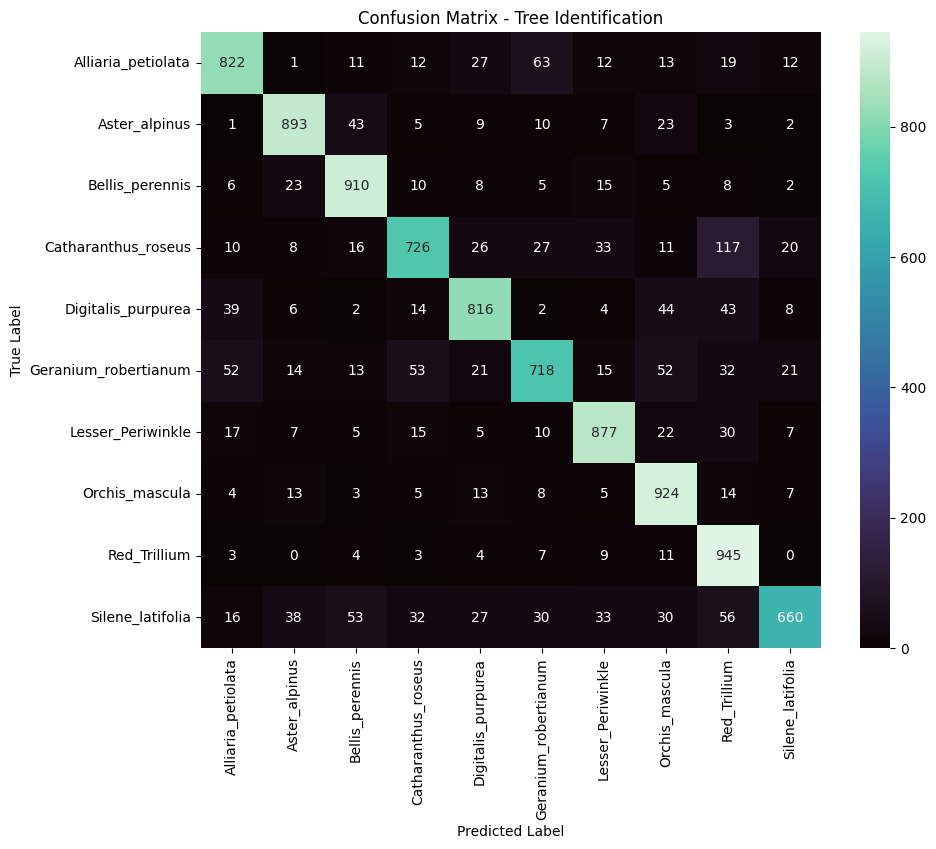

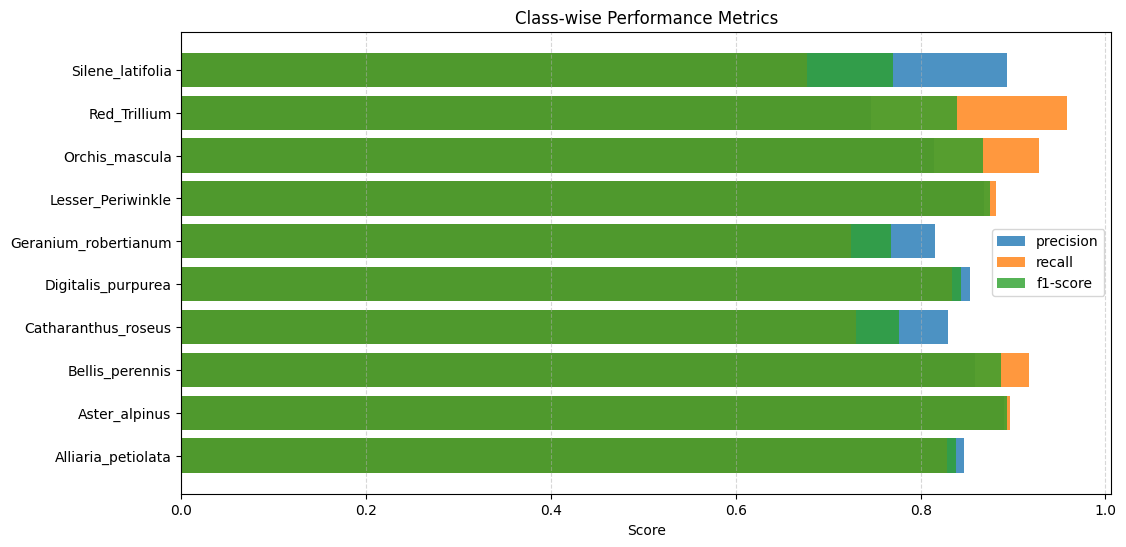

In [5]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import json
from sklearn.metrics import classification_report, confusion_matrix
from tensorflow import keras

# Load model and class indices
uploaded_model_path = "/kaggle/input/final-10-flowers/model_epoch_15.keras"
class_indices_path = "/kaggle/input/final-10-flowers/class_indices (11).json"

with open(class_indices_path, "r") as f:
    class_indices = json.load(f)
inv_class_indices = {v: k for k, v in class_indices.items()}

model = keras.models.load_model(uploaded_model_path)

# Evaluation
val_steps = int(np.ceil(val_generator.samples / val_generator.batch_size))

y_true = val_generator.classes
y_pred = np.argmax(model.predict(val_generator, steps=val_steps), axis=1)

# Classification Report
report = classification_report(y_true, y_pred, target_names=list(class_indices.keys()), output_dict=True)

# Confusion Matrix
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='mako', xticklabels=inv_class_indices.values(), yticklabels=inv_class_indices.values())
plt.title('Confusion Matrix - Tree Identification')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.savefig("confusion_matrix.png", dpi=300, bbox_inches='tight')
plt.show()

# Performance Metrics
metrics = ['precision', 'recall', 'f1-score']
plt.figure(figsize=(12, 6))
for i, metric in enumerate(metrics):
    scores = [report[cls][metric] for cls in class_indices.keys()]
    plt.barh(list(class_indices.keys()), scores, label=metric, alpha=0.8)

plt.title("Class-wise Performance Metrics")
plt.xlabel("Score")
plt.legend()
plt.grid(axis='x', linestyle='--', alpha=0.5)
plt.savefig("performance_metrics.png", dpi=300, bbox_inches='tight')
plt.show()


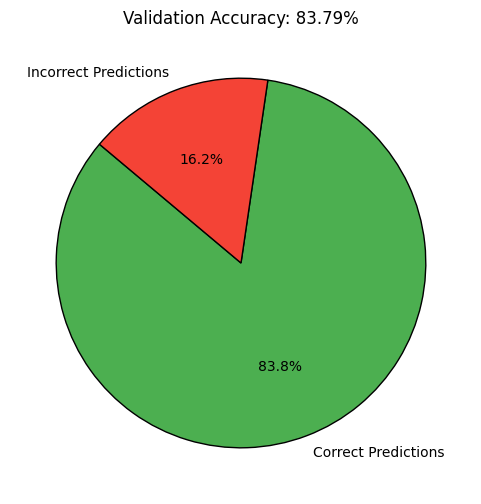

In [6]:
# Calculate Validation Accuracy
accuracy = np.mean(y_true == y_pred)

# Visualization of Validation Accuracy
plt.figure(figsize=(6, 6))
plt.pie(
    [accuracy, 1 - accuracy],
    labels=['Correct Predictions', 'Incorrect Predictions'],
    colors=['#4CAF50', '#F44336'],
    autopct='%1.1f%%',
    startangle=140,
    wedgeprops={'edgecolor': 'black'}
)
plt.title(f'Validation Accuracy: {accuracy * 100:.2f}%')
plt.savefig("validation_accuracy.png", dpi=300, bbox_inches='tight')
plt.show()


In [7]:
# Calculate Validation Accuracy
accuracy = np.mean(y_true == y_pred)

# Visualization of Validation Accuracy
plt.figure(figsize=(6, 6))
plt.pie(
    [accuracy, 1 - accuracy],
    labels=['Correct Predictions', 'Incorrect Predictions'],
    colors=['#4CAF50', '#F44336'],
    autopct='%1.1f%%',
    startangle=140,
    wedgeprops={'edgecolor': 'black'}
)
plt.title(f'Validation Accuracy: {accuracy * 100:.2f}%')

# Save the plot
plt.savefig("validation_accuracy.png", dpi=300, bbox_inches='tight')
plt.close()  # Close the plot to avoid displaying it twice


In [9]:
import matplotlib.pyplot as plt
from matplotlib.patches import Wedge

# Calculate Validation Accuracy
accuracy = np.mean(y_true == y_pred) * 100

# Gauge-Style Plot
fig, ax = plt.subplots(figsize=(6, 6))
ax.set_aspect('equal')

# Background (full circle)
ax.add_patch(Wedge((0.5, 0.5), 0.4, 0, 360, color='#d3d3d3'))

# Accuracy Arc
ax.add_patch(Wedge((0.5, 0.5), 0.4, 0, accuracy * 3.6, color='#4CAF50'))

# Text Display
ax.text(0.5, 0.5, f"{accuracy:.2f}%", fontsize=24, ha='center', va='center', fontweight='bold')

# Clean Layout
ax.axis('off')
plt.title('Validation Accuracy', fontsize=16, pad=20)

# Save as Image
plt.savefig("validation_accuracy_gauge.png", dpi=300, bbox_inches='tight')
plt.close()


In [10]:
import matplotlib.pyplot as plt

# Calculate Validation Accuracy
accuracy = np.mean(y_true == y_pred) * 100

# Progress Bar Plot
plt.figure(figsize=(8, 2))
plt.barh(['Validation Accuracy'], [accuracy], color='#4CAF50')
plt.barh(['Validation Accuracy'], [100], color='#d3d3d3', alpha=0.5)

# Display Accuracy Value
plt.text(accuracy - 5, 0, f"{accuracy:.2f}%", va='center', ha='right', fontsize=14, color='white', fontweight='bold')

# Clean Layout
plt.xlim(0, 100)
plt.gca().axes.get_yaxis().set_visible(False)  # Hide y-axis for cleaner look
plt.title('Validation Accuracy', fontsize=16, pad=10)

# Save as Image
plt.savefig("validation_accuracy_progress.png", dpi=300, bbox_inches='tight')
plt.close()


In [ ]:
# import os
# import json
# import numpy as np
# import tensorflow as tf
# from tensorflow.keras.applications.efficientnet import preprocess_input
# from tensorflow.keras.preprocessing import image
# from tensorflow.keras.models import load_model
# import matplotlib.pyplot as plt
# from tkinter import Tk, filedialog

# # ==============================
# # 1) Load Model and Class Indices
# # ==============================
# model_path = "/kaggle/input/flowers6testing/latest_model.keras"  # Update as needed
# class_indices_path = "/kaggle/input/flowers6testing/class_indices (11).json"

# model = load_model(model_path)
# with open(class_indices_path, 'r') as f:
#     class_indices = json.load(f)
# inv_class_indices = {v: k for k, v in class_indices.items()}

# # ==============================
# # 2) Select Image from PC
# # ==============================
# def select_image():
#     root = Tk()
#     root.withdraw()  # Hide the main window
#     file_path = filedialog.askopenfilename(title="Select Image", filetypes=[("Image Files", "*.jpg;*.jpeg;*.png")])
#     return file_path

# image_path = select_image()

# # ==============================
# # 3) Preprocess Image for Prediction
# # ==============================
# def preprocess_img(img_path):
#     img = image.load_img(img_path, target_size=(240, 240))
#     img_array = image.img_to_array(img)
#     img_array = np.expand_dims(img_array, axis=0)
#     return preprocess_input(img_array)

# img_array = preprocess_img(image_path)

# # ==============================
# # 4) Prediction & Display
# # ==============================
# preds = model.predict(img_array)
# pred_class = np.argmax(preds[0])
# predicted_label = inv_class_indices[pred_class]

# # Display Results
# plt.imshow(image.load_img(image_path))
# plt.axis('off')
# plt.title(f"Predicted: {predicted_label}")
# plt.show()

In [ ]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.applications.efficientnet import preprocess_input
from tensorflow.keras.preprocessing import image
import json
import os

# Paths
uploaded_model_path = "/kaggle/input/flowers6testing/latest_model.keras"  # Update if needed
class_indices_path = "/kaggle/input/flowers6testing/class_indices (11).json"   # Update if needed
image_path = "/kaggle/input/cath-tset/cath5.png"  # Change this after uploading your image

# Load class indices
with open(class_indices_path, "r") as f:
    class_indices = json.load(f)
class_labels = {v: k for k, v in class_indices.items()}

# Load model
model = tf.keras.models.load_model(uploaded_model_path)

# Load and preprocess image
def preprocess_image(image_path, target_size=(240, 240)):
    img = image.load_img(image_path, target_size=target_size)
    img_array = image.img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)
    return preprocess_input(img_array)

# Prediction
img_array = preprocess_image(image_path)
prediction = model.predict(img_array)
predicted_class = class_labels[np.argmax(prediction)]

print(f"✅ Predicted Class: {predicted_class}")


In [ ]:
import os
import json
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau, TensorBoard
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import datetime

# ====================================
# 1) CONFIGURATION & PATHS
# ====================================
image_dir = "/kaggle/input/trees-nineteen-dataset"  # Update this with your dataset path
save_dir = "/kaggle/working"
os.makedirs(save_dir, exist_ok=True)

model_prefix = os.path.join(save_dir, "model_epoch_")
uploaded_model_path = "/kaggle/input/latest_flower_model_nineteen/latest_model.keras"  # Update this manually
tmp_model_path = os.path.join(save_dir, "latest_model.keras")
history_path = os.path.join(save_dir, "history.json")
class_indices_path = os.path.join(save_dir, "class_indices.json")
log_dir = os.path.join(save_dir, "logs", datetime.datetime.now().strftime("%Y%m%d-%H%M%S"))

batch_size = 64
input_shape = (256, 256, 3)  # Swin Transformer Tiny expects 256x256
initial_learning_rate = 5e-6
fine_tune_learning_rate = 1e-5

# ====================================
# 2) DETECT CLASSES & BUILD CLASS INDICES
# ====================================
detected_classes = sorted(d for d in os.listdir(image_dir) if os.path.isdir(os.path.join(image_dir, d)))

if os.path.exists(class_indices_path):
    with open(class_indices_path, "r") as f:
        class_indices = json.load(f)
else:
    class_indices = {name: i for i, name in enumerate(detected_classes)}
    with open(class_indices_path, "w") as f:
        json.dump(class_indices, f)
num_classes = len(class_indices)
print("Class indices:", class_indices)

# ====================================
# 3) DATA AUGMENTATION & PREPROCESSING
# ====================================
from tensorflow.keras.applications.swin_transformer import preprocess_input

datagen = ImageDataGenerator(
    preprocessing_function=preprocess_input,
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.25,
    horizontal_flip=True,
    brightness_range=[0.7, 1.3],
    fill_mode="nearest",
    validation_split=0.2
)

train_generator = datagen.flow_from_directory(
    directory=image_dir,
    target_size=input_shape[:2],
    batch_size=batch_size,
    class_mode='categorical',
    subset='training',
    shuffle=True,
    classes=list(class_indices.keys())
)

val_generator = datagen.flow_from_directory(
    directory=image_dir,
    target_size=input_shape[:2],
    batch_size=batch_size,
    class_mode='categorical',
    subset='validation',
    shuffle=False,
    classes=list(class_indices.keys())
)

# ====================================
# 4) DEFINE Swin Transformer Tiny MODEL
# ====================================
def create_model(fine_tune=False):
    base_model = keras.applications.SwinTransformerTiny(
        include_top=False,
        weights="imagenet",
        input_shape=input_shape
    )
    
    if fine_tune:
        base_model.trainable = True
        fine_tune_at = len(base_model.layers) - 50  # Unfreezing last 50 layers
        for layer in base_model.layers[:fine_tune_at]:
            layer.trainable = False
        learning_rate = fine_tune_learning_rate
    else:
        base_model.trainable = False
        learning_rate = initial_learning_rate
    
    model = keras.Sequential([
        keras.Input(shape=input_shape),
        base_model,
        layers.GlobalAveragePooling2D(),
        layers.BatchNormalization(),
        layers.Dense(512, activation='relu'),
        layers.Dropout(0.5),
        layers.Dense(num_classes, activation='softmax')
    ])
    
    optimizer = keras.optimizers.AdamW(learning_rate=learning_rate)
    model.compile(
        optimizer=optimizer,
        loss='categorical_crossentropy',
        metrics=['accuracy']
    )
    return model

# ====================================
# 5) LOAD PREVIOUS MODEL (IF RESUMING)
# ====================================
if os.path.exists(uploaded_model_path):
    fine_tune_model = create_model(fine_tune=True)
    fine_tune_model.load_weights(uploaded_model_path)
    print("✅ Loaded latest model. Fine-tuning...")
else:
    print("🚀 Training from scratch with Swin Transformer Tiny!")
    fine_tune_model = create_model(fine_tune=False)

# ====================================
# 6) TRAINING FUNCTION WITH CALLBACKS
# ====================================
def train_model_func(model, epochs, start_epoch=1):
    callbacks = [
        ModelCheckpoint(tmp_model_path, save_best_only=True, verbose=1),
        ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, verbose=1, min_lr=1e-7),
        EarlyStopping(monitor='val_loss', patience=6, restore_best_weights=True),
        TensorBoard(log_dir=log_dir)
    ]
    
    for epoch in range(start_epoch, start_epoch + epochs):
        print(f"\n🔄 Training Epoch {epoch}/{start_epoch + epochs - 1}...")
        model.fit(train_generator, validation_data=val_generator, epochs=1, callbacks=callbacks)
        
        model_epoch_path = f"{model_prefix}{epoch}.keras"
        model.save(model_epoch_path)
        model.save(tmp_model_path)
        print(f"✅ Model saved: {model_epoch_path}")
    
    print("✅ Training session complete!")

# ====================================
# 7) INITIAL TRAINING PHASE (15 EPOCHS)
# ====================================
print("\n=== Initial Training Phase (Swin Transformer Tiny) ===")
train_model_func(fine_tune_model, epochs=15, start_epoch=1)

# ====================================
# 8) FINE-TUNING PHASE (OPTIONAL)
# ====================================

# print("\n=== Fine-Tuning Phase ===")
# fine_tune_model = create_model(fine_tune=True)
# fine_tune_model.load_weights(uploaded_model_path)
# train_model_func(fine_tune_model, epochs=4, start_epoch=4)


In [ ]:
pip install keras-cv


In [ ]:
pip install timm


In [ ]:
import os
import json
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau, TensorBoard
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import keras_cv
import datetime

# ====================================
# 1) CONFIGURATION & PATHS
# ====================================
image_dir = "/kaggle/input/trees-nineteen-dataset"  
save_dir = "/kaggle/working"
os.makedirs(save_dir, exist_ok=True)

model_prefix = os.path.join(save_dir, "model_epoch_")
uploaded_model_path = "/kaggle/input/latest_flower_model_nineteen/latest_model.keras"  
tmp_model_path = os.path.join(save_dir, "latest_model.keras")
history_path = os.path.join(save_dir, "history.json")
class_indices_path = os.path.join(save_dir, "class_indices.json")
log_dir = os.path.join(save_dir, "logs", datetime.datetime.now().strftime("%Y%m%d-%H%M%S"))

batch_size = 64
input_shape = (224, 224, 3)  # Swin Transformer prefers 224x224
initial_learning_rate = 5e-6
fine_tune_learning_rate = 1e-5

# ====================================
# 2) DETECT CLASSES & BUILD CLASS INDICES
# ====================================
detected_classes = sorted(d for d in os.listdir(image_dir) if os.path.isdir(os.path.join(image_dir, d)))

if os.path.exists(class_indices_path):
    with open(class_indices_path, "r") as f:
        class_indices = json.load(f)
else:
    class_indices = {name: i for i, name in enumerate(detected_classes)}
    with open(class_indices_path, "w") as f:
        json.dump(class_indices, f)
num_classes = len(class_indices)
print("Class indices:", class_indices)

# ====================================
# 3) DATA AUGMENTATION & PREPROCESSING
# ====================================
datagen = ImageDataGenerator(
    preprocessing_function=None,  # Swin Transformer does not require a built-in preprocessing function
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.25,
    horizontal_flip=True,
    brightness_range=[0.7, 1.3],
    fill_mode="nearest",
    validation_split=0.2
)

train_generator = datagen.flow_from_directory(
    directory=image_dir,
    target_size=input_shape[:2],
    batch_size=batch_size,
    class_mode='categorical',
    subset='training',
    shuffle=True,
    classes=list(class_indices.keys())
)

val_generator = datagen.flow_from_directory(
    directory=image_dir,
    target_size=input_shape[:2],
    batch_size=batch_size,
    class_mode='categorical',
    subset='validation',
    shuffle=False,
    classes=list(class_indices.keys())
)

# ====================================
# 4) DEFINE SWIN TRANSFORMER MODEL
# ====================================
def create_model(fine_tune=False):
    base_model = keras_cv.models.SwinTransformerTiny(
        include_top=False,
        input_shape=input_shape,
        pretrained=True
    )

    if fine_tune:
        base_model.trainable = True
        fine_tune_at = len(base_model.layers) - 50  # Unfreezing last 50 layers
        for layer in base_model.layers[:fine_tune_at]:
            layer.trainable = False
        learning_rate = fine_tune_learning_rate
    else:
        base_model.trainable = False
        learning_rate = initial_learning_rate

    model = keras.Sequential([
        keras.Input(shape=input_shape),
        base_model,
        layers.GlobalAveragePooling2D(),
        layers.BatchNormalization(),
        layers.Dense(512, activation='relu'),
        layers.Dropout(0.5),
        layers.Dense(num_classes, activation='softmax')
    ])
    
    optimizer = keras.optimizers.AdamW(learning_rate=learning_rate)
    model.compile(
        optimizer=optimizer,
        loss='categorical_crossentropy',
        metrics=['accuracy']
    )
    return model

# ====================================
# 5) LOAD PREVIOUS MODEL (IF RESUMING)
# ====================================
if os.path.exists(uploaded_model_path):
    fine_tune_model = create_model(fine_tune=True)
    fine_tune_model.load_weights(uploaded_model_path)
    print("✅ Loaded latest model. Fine-tuning...")
else:
    print("🚀 Training from scratch with Swin Transformer!")
    fine_tune_model = create_model(fine_tune=False)

# ====================================
# 6) TRAINING FUNCTION WITH CALLBACKS
# ====================================
def train_model_func(model, epochs, start_epoch=1):
    callbacks = [
        ModelCheckpoint(tmp_model_path, save_best_only=True, verbose=1),
        ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, verbose=1, min_lr=1e-7),
        EarlyStopping(monitor='val_loss', patience=6, restore_best_weights=True),
        TensorBoard(log_dir=log_dir)
    ]
    
    for epoch in range(start_epoch, start_epoch + epochs):
        print(f"\n🔄 Training Epoch {epoch}/{start_epoch + epochs - 1}...")
        model.fit(train_generator, validation_data=val_generator, epochs=1, callbacks=callbacks)
        
        model_epoch_path = f"{model_prefix}{epoch}.keras"
        model.save(model_epoch_path)
        model.save(tmp_model_path)
        print(f"✅ Model saved: {model_epoch_path}")
    
    print("✅ Training session complete!")

# ====================================
# 7) INITIAL TRAINING PHASE (15 EPOCHS)
# ====================================
print("\n=== Initial Training Phase (Swin Transformer Tiny) ===")
train_model_func(fine_tune_model, epochs=15, start_epoch=1)


In [ ]:
import os
import json
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau, TensorBoard
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import timm
from tensorflow.keras.applications.imagenet_utils import preprocess_input

import datetime

# ====================================
# 1) CONFIGURATION & PATHS
# ====================================
image_dir = "/kaggle/input/trees-nineteen-dataset"  # Update this with your dataset path
save_dir = "/kaggle/working"
os.makedirs(save_dir, exist_ok=True)

model_prefix = os.path.join(save_dir, "model_epoch_")
uploaded_model_path = "/kaggle/input/latest_flower_model_nineteen/latest_model.keras"  # Update this manually
tmp_model_path = os.path.join(save_dir, "latest_model.keras")
history_path = os.path.join(save_dir, "history.json")
class_indices_path = os.path.join(save_dir, "class_indices.json")
log_dir = os.path.join(save_dir, "logs", datetime.datetime.now().strftime("%Y%m%d-%H%M%S"))

batch_size = 64
input_shape = (224, 224, 3)  # Swin Transformer prefers 224x224
initial_learning_rate = 5e-6
fine_tune_learning_rate = 1e-5

# ====================================
# 2) DETECT CLASSES & BUILD CLASS INDICES
# ====================================
detected_classes = sorted(d for d in os.listdir(image_dir) if os.path.isdir(os.path.join(image_dir, d)))

if os.path.exists(class_indices_path):
    with open(class_indices_path, "r") as f:
        class_indices = json.load(f)
else:
    class_indices = {name: i for i, name in enumerate(detected_classes)}
    with open(class_indices_path, "w") as f:
        json.dump(class_indices, f)
num_classes = len(class_indices)
print("Class indices:", class_indices)

# ====================================
# 3) DATA AUGMENTATION & PREPROCESSING
# ====================================


# datagen = ImageDataGenerator(
#     preprocessing_function=preprocess_input,
#     rotation_range=40,
#     width_shift_range=0.2,
#     height_shift_range=0.2,
#     shear_range=0.2,
#     zoom_range=0.25,
#     horizontal_flip=True,
#     brightness_range=[0.7, 1.3],
#     fill_mode="nearest",
#     validation_split=0.2
# )
datagen = ImageDataGenerator(
    preprocessing_function=lambda x: (x / 255.0 - 0.5) * 2,  # Normalize between -1 and 1
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.25,
    horizontal_flip=True,
    brightness_range=[0.7, 1.3],
    fill_mode="nearest",
    validation_split=0.2
)


train_generator = datagen.flow_from_directory(
    directory=image_dir,
    target_size=input_shape[:2],
    batch_size=batch_size,
    class_mode='categorical',
    subset='training',
    shuffle=True,
    classes=list(class_indices.keys())
)

val_generator = datagen.flow_from_directory(
    directory=image_dir,
    target_size=input_shape[:2],
    batch_size=batch_size,
    class_mode='categorical',
    subset='validation',
    shuffle=False,
    classes=list(class_indices.keys())
)

# ====================================
# 4) DEFINE Swin Transformer Tiny MODEL
# ====================================
# def create_model(fine_tune=False):
#     base_model = keras.applications.SwinTransformerTiny(
#         include_top=False,
#         weights="imagenet",
#         input_shape=input_shape
#     )
    
#     if fine_tune:
#         base_model.trainable = True
#         fine_tune_at = len(base_model.layers) - 50  # Unfreezing last 50 layers
#         for layer in base_model.layers[:fine_tune_at]:
#             layer.trainable = False
#         learning_rate = fine_tune_learning_rate
#     else:
#         base_model.trainable = False
#         learning_rate = initial_learning_rate
    
#     model = keras.Sequential([
#         keras.Input(shape=input_shape),
#         base_model,
#         layers.GlobalAveragePooling2D(),
#         layers.BatchNormalization(),
#         layers.Dense(512, activation='relu'),
#         layers.Dropout(0.5),
#         layers.Dense(num_classes, activation='softmax')
#     ])
    
#     optimizer = keras.optimizers.AdamW(learning_rate=learning_rate)
#     model.compile(
#         optimizer=optimizer,
#         loss='categorical_crossentropy',
#         metrics=['accuracy']
#     )
#     return model
def create_model(fine_tune=False):
    base_model = timm.create_model("swin_tiny_patch4_window7_224", pretrained=True, num_classes=0)
    base_model.trainable = fine_tune  # Freeze if fine_tune=False
    
    model = keras.Sequential([
        keras.Input(shape=input_shape),
        layers.Lambda(lambda x: tf.image.resize(x, (224, 224))),  # Resize for Swin Transformer
        base_model,
        layers.GlobalAveragePooling2D(),

        layers.BatchNormalization(),
        layers.Dense(512, activation='relu'),
        layers.Dropout(0.5),
        layers.Dense(num_classes, activation='softmax')
    ])
    
    optimizer = keras.optimizers.AdamW(learning_rate=fine_tune_learning_rate if fine_tune else initial_learning_rate)
    model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])
    return model


# ====================================
# 5) LOAD PREVIOUS MODEL (IF RESUMING)
# ====================================
if os.path.exists(uploaded_model_path):
    fine_tune_model = create_model(fine_tune=True)
    fine_tune_model.load_weights(uploaded_model_path)
    print("✅ Loaded latest model. Fine-tuning...")
else:
    print("🚀 Training from scratch with Swin Transformer Tiny!")
    fine_tune_model = create_model(fine_tune=False)

# ====================================
# 6) TRAINING FUNCTION WITH CALLBACKS
# ====================================
def train_model_func(model, epochs, start_epoch=1):
    callbacks = [
        ModelCheckpoint(tmp_model_path, save_best_only=True, verbose=1),
        ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, verbose=1, min_lr=1e-7),
        EarlyStopping(monitor='val_loss', patience=6, restore_best_weights=True),
        TensorBoard(log_dir=log_dir)
    ]
    
    for epoch in range(start_epoch, start_epoch + epochs):
        print(f"\n🔄 Training Epoch {epoch}/{start_epoch + epochs - 1}...")
        model.fit(train_generator, validation_data=val_generator, epochs=1, callbacks=callbacks)
        
        model_epoch_path = f"{model_prefix}{epoch}.keras"
        model.save(model_epoch_path)
        model.save(tmp_model_path)
        print(f"✅ Model saved: {model_epoch_path}")
    
    print("✅ Training session complete!")

# ====================================
# 7) INITIAL TRAINING PHASE (15 EPOCHS)
# ====================================
print("\n=== Initial Training Phase (Swin Transformer Tiny) ===")
train_model_func(fine_tune_model, epochs=15, start_epoch=1)

In [ ]:
!pip install timm


In [ ]:
import os
import json
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau, TensorBoard
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import datetime

# ====================================
# 1) CONFIGURATION & PATHS
# ====================================
image_dir = "/kaggle/input/flowers-nineteen19"  # Update this with your dataset path
save_dir = "/kaggle/working"
os.makedirs(save_dir, exist_ok=True)

model_prefix = os.path.join(save_dir, "model_epoch_")
uploaded_model_path = "/kaggle/input/latest_flower_model_nineteen/latest_model.keras"  # Update this manually
tmp_model_path = os.path.join(save_dir, "latest_model.keras")
history_path = os.path.join(save_dir, "history.json")
class_indices_path = os.path.join(save_dir, "class_indices.json")
log_dir = os.path.join(save_dir, "logs", datetime.datetime.now().strftime("%Y%m%d-%H%M%S"))

batch_size = 64
input_shape = (300, 300, 3)  # EfficientNetB3 prefers 300x300
initial_learning_rate = 5e-6
fine_tune_learning_rate = 1e-5

# ====================================
# 2) DETECT CLASSES & BUILD CLASS INDICES
# ====================================
detected_classes = sorted(d for d in os.listdir(image_dir) if os.path.isdir(os.path.join(image_dir, d)))

if os.path.exists(class_indices_path):
    with open(class_indices_path, "r") as f:
        class_indices = json.load(f)
else:
    class_indices = {name: i for i, name in enumerate(detected_classes)}
    with open(class_indices_path, "w") as f:
        json.dump(class_indices, f)
num_classes = len(class_indices)
print("Class indices:", class_indices)

# ====================================
# 3) DATA AUGMENTATION & PREPROCESSING
# ====================================
from tensorflow.keras.applications.efficientnet import preprocess_input

datagen = ImageDataGenerator(
    preprocessing_function=preprocess_input,
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.25,
    horizontal_flip=True,
    brightness_range=[0.7, 1.3],
    fill_mode="nearest",
    validation_split=0.2
)

train_generator = datagen.flow_from_directory(
    directory=image_dir,
    target_size=input_shape[:2],
    batch_size=batch_size,
    class_mode='categorical',
    subset='training',
    shuffle=True,
    classes=list(class_indices.keys())
)

val_generator = datagen.flow_from_directory(
    directory=image_dir,
    target_size=input_shape[:2],
    batch_size=batch_size,
    class_mode='categorical',
    subset='validation',
    shuffle=False,
    classes=list(class_indices.keys())
)

# ====================================
# 4) DEFINE EfficientNetB3 MODEL
# ====================================
def create_model(fine_tune=False):
    base_model = keras.applications.EfficientNetB3(
        include_top=False,
        weights="imagenet",
        input_shape=input_shape
    )
    
    if fine_tune:
        base_model.trainable = True
        fine_tune_at = len(base_model.layers) - 200  # Unfreezing last 200 layers
        for layer in base_model.layers[:fine_tune_at]:
            layer.trainable = False
        learning_rate = fine_tune_learning_rate
    else:
        base_model.trainable = False
        learning_rate = initial_learning_rate
    
    model = keras.Sequential([
        keras.Input(shape=input_shape),
        base_model,
        layers.GlobalAveragePooling2D(),
        layers.BatchNormalization(),
        layers.Dense(512, activation='relu'),
        layers.Dropout(0.5),
        layers.Dense(num_classes, activation='softmax')
    ])
    
    optimizer = keras.optimizers.AdamW(learning_rate=learning_rate)
    model.compile(
        optimizer=optimizer,
        loss='categorical_crossentropy',
        metrics=['accuracy']
    )
    return model

# ====================================
# 5) LOAD PREVIOUS MODEL (IF RESUMING)
# ====================================
if os.path.exists(uploaded_model_path):
    fine_tune_model = create_model(fine_tune=True)
    fine_tune_model.load_weights(uploaded_model_path)
    print("✅ Loaded latest model. Fine-tuning...")
else:
    print("🚀 Training from scratch with EfficientNetB3!")
    fine_tune_model = create_model(fine_tune=False)

# ====================================
# 6) TRAINING FUNCTION WITH CALLBACKS
# ====================================
def train_model_func(model, epochs, start_epoch=1):
    callbacks = [
        ModelCheckpoint(tmp_model_path, save_best_only=True, verbose=1),
        ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, verbose=1, min_lr=1e-7),
        EarlyStopping(monitor='val_loss', patience=6, restore_best_weights=True),
        TensorBoard(log_dir=log_dir)
    ]
    
    for epoch in range(start_epoch, start_epoch + epochs):
        print(f"\n🔄 Training Epoch {epoch}/{start_epoch + epochs - 1}...")
        model.fit(train_generator, validation_data=val_generator, epochs=1, callbacks=callbacks)
        
        model_epoch_path = f"{model_prefix}{epoch}.keras"
        model.save(model_epoch_path)
        model.save(tmp_model_path)
        print(f"✅ Model saved: {model_epoch_path}")
    
    print("✅ Training session complete!")

# ====================================
# 7) INITIAL TRAINING PHASE (3 EPOCHS)
# ====================================
print("\n=== Initial Training Phase (EfficientNetB3) ===")
train_model_func(fine_tune_model, epochs=15, start_epoch=1)


In [ ]:
import os
import json
import shutil
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau, TensorBoard
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import datetime

# ====================================
# 1) CONFIGURATION & PATHS
# ====================================
image_dir = "/kaggle/input/flowers-nineteen19"  # Update this with your dataset path
save_dir = "/kaggle/working"
os.makedirs(save_dir, exist_ok=True)

model_prefix = os.path.join(save_dir, "model_epoch_")
uploaded_model_path = "/kaggle/input/latest_flower_model_nineteen/latest_model.keras"  # Update this manually
tmp_model_path = os.path.join(save_dir, "latest_model.keras")
history_path = os.path.join(save_dir, "history.json")
class_indices_path = os.path.join(save_dir, "class_indices.json")
log_dir = os.path.join(save_dir, "logs", datetime.datetime.now().strftime("%Y%m%d-%H%M%S"))

batch_size = 64
input_shape = (224, 224, 3)  # EfficientNetB3 prefers 300x300
initial_learning_rate = 5e-6
fine_tune_learning_rate = 1e-5

# ====================================
# 2) FIX DATASET STRUCTURE
# ====================================
for class_name in os.listdir(image_dir):
    class_path = os.path.join(image_dir, class_name)
    if os.path.isdir(class_path):
        subfolders = [f for f in os.listdir(class_path) if os.path.isdir(os.path.join(class_path, f))]
        for subfolder in subfolders:
            subfolder_path = os.path.join(class_path, subfolder)
            for file in os.listdir(subfolder_path):
                src_path = os.path.join(subfolder_path, file)
                dst_path = os.path.join(class_path, file)
                shutil.move(src_path, dst_path)
            os.rmdir(subfolder_path)
print("✅ Dataset structure fixed!")

# ====================================
# 3) DETECT CLASSES & BUILD CLASS INDICES
# ====================================
detected_classes = sorted(d for d in os.listdir(image_dir) if os.path.isdir(os.path.join(image_dir, d)))

if os.path.exists(class_indices_path):
    with open(class_indices_path, "r") as f:
        class_indices = json.load(f)
else:
    class_indices = {name: i for i, name in enumerate(detected_classes)}
    with open(class_indices_path, "w") as f:
        json.dump(class_indices, f)
num_classes = len(class_indices)
print("Class indices:", class_indices)

# ====================================
# 4) DATA AUGMENTATION & PREPROCESSING
# ====================================
from tensorflow.keras.applications.efficientnet import preprocess_input

datagen = ImageDataGenerator(
    preprocessing_function=preprocess_input,
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.25,
    horizontal_flip=True,
    brightness_range=[0.7, 1.3],
    fill_mode="nearest",
    validation_split=0.2
)

train_generator = datagen.flow_from_directory(
    directory=image_dir,
    target_size=input_shape[:2],
    batch_size=batch_size,
    class_mode='categorical',
    subset='training',
    shuffle=True,
    classes=list(class_indices.keys())
)

val_generator = datagen.flow_from_directory(
    directory=image_dir,
    target_size=input_shape[:2],
    batch_size=batch_size,
    class_mode='categorical',
    subset='validation',
    shuffle=False,
    classes=list(class_indices.keys())
)

# ====================================
# 5) DEFINE EfficientNetB3 MODEL
# ====================================
def create_model(fine_tune=False):
    base_model = keras.applications.EfficientNetB3(
        include_top=False,
        weights="imagenet",
        input_shape=input_shape
    )
    
    if fine_tune:
        base_model.trainable = True
        fine_tune_at = len(base_model.layers) - 200  # Unfreezing last 200 layers
        for layer in base_model.layers[:fine_tune_at]:
            layer.trainable = False
        learning_rate = fine_tune_learning_rate
    else:
        base_model.trainable = False
        learning_rate = initial_learning_rate
    
    model = keras.Sequential([
        keras.Input(shape=input_shape),
        base_model,
        layers.GlobalAveragePooling2D(),
        layers.BatchNormalization(),
        layers.Dense(512, activation='relu'),
        layers.Dropout(0.5),
        layers.Dense(num_classes, activation='softmax')
    ])
    
    optimizer = keras.optimizers.AdamW(learning_rate=learning_rate)
    model.compile(
        optimizer=optimizer,
        loss='categorical_crossentropy',
        metrics=['accuracy']
    )
    return model

# ====================================
# 6) LOAD PREVIOUS MODEL (IF RESUMING)
# ====================================
if os.path.exists(uploaded_model_path):
    fine_tune_model = create_model(fine_tune=True)
    fine_tune_model.load_weights(uploaded_model_path)
    print("✅ Loaded latest model. Fine-tuning...")
else:
    print("🚀 Training from scratch with EfficientNetB3!")
    fine_tune_model = create_model(fine_tune=False)

# ====================================
# 7) TRAINING FUNCTION WITH CALLBACKS
# ====================================
def train_model_func(model, epochs, start_epoch=1):
    callbacks = [
        ModelCheckpoint(tmp_model_path, save_best_only=True, verbose=1),
        ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, verbose=1, min_lr=1e-7),
        EarlyStopping(monitor='val_loss', patience=6, restore_best_weights=True),
        TensorBoard(log_dir=log_dir)
    ]
    
    for epoch in range(start_epoch, start_epoch + epochs):
        print(f"\n🔄 Training Epoch {epoch}/{start_epoch + epochs - 1}...")
        model.fit(train_generator, validation_data=val_generator, epochs=1, callbacks=callbacks)
        
        model_epoch_path = f"{model_prefix}{epoch}.keras"
        model.save(model_epoch_path)
        model.save(tmp_model_path)
        print(f"✅ Model saved: {model_epoch_path}")
    
    print("✅ Training session complete!")

# ====================================
# 8) INITIAL TRAINING PHASE (15 EPOCHS)
# ====================================
print("\n=== Initial Training Phase (EfficientNetB3) ===")
train_model_func(fine_tune_model, epochs=15, start_epoch=1)

In [ ]:
import os
import json
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau, TensorBoard
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import datetime

# ====================================
# 1) CONFIGURATION & PATHS
# ====================================
image_dir = "/kaggle/input/flowers-nineteen19"  # Update this with your dataset path
save_dir = "/kaggle/working"
os.makedirs(save_dir, exist_ok=True)

model_prefix = os.path.join(save_dir, "model_epoch_")
uploaded_model_path = "/kaggle/input/latest_flower_model_nineteen/latest_model.keras"  # Update this manually
tmp_model_path = os.path.join(save_dir, "latest_model.keras")
history_path = os.path.join(save_dir, "history.json")
class_indices_path = os.path.join(save_dir, "class_indices.json")
log_dir = os.path.join(save_dir, "logs", datetime.datetime.now().strftime("%Y%m%d-%H%M%S"))

batch_size = 64
input_shape = (224, 224, 3)  # EfficientNetB3 prefers 300x300
initial_learning_rate = 5e-6
fine_tune_learning_rate = 1e-5

# ====================================
# 2) DETECT CLASSES & BUILD CLASS INDICES
# ====================================
detected_classes = sorted(d for d in os.listdir(image_dir) if os.path.isdir(os.path.join(image_dir, d)))

if os.path.exists(class_indices_path):
    with open(class_indices_path, "r") as f:
        class_indices = json.load(f)
else:
    class_indices = {name: i for i, name in enumerate(detected_classes)}
    with open(class_indices_path, "w") as f:
        json.dump(class_indices, f)
num_classes = len(class_indices)
print("Class indices:", class_indices)

# ====================================
# 3) DATA AUGMENTATION & PREPROCESSING
# ====================================
from tensorflow.keras.applications.efficientnet import preprocess_input

datagen = ImageDataGenerator(
    preprocessing_function=preprocess_input,
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.25,
    horizontal_flip=True,
    brightness_range=[0.7, 1.3],
    fill_mode="nearest",
    validation_split=0.2
)

train_generator = datagen.flow_from_directory(
    directory=image_dir,
    target_size=input_shape[:2],
    batch_size=batch_size,
    class_mode='categorical',
    subset='training',
    shuffle=True,
    classes=list(class_indices.keys())
)

val_generator = datagen.flow_from_directory(
    directory=image_dir,
    target_size=input_shape[:2],
    batch_size=batch_size,
    class_mode='categorical',
    subset='validation',
    shuffle=False,
    classes=list(class_indices.keys())
)

# ====================================
# 4) DEFINE EfficientNetB3 MODEL
# ====================================
def create_model(fine_tune=False):
    base_model = keras.applications.EfficientNetB3(
        include_top=False,
        weights="imagenet",
        input_shape=input_shape
    )
    
    if fine_tune:
        base_model.trainable = True
        fine_tune_at = len(base_model.layers) - 200  # Unfreezing last 200 layers
        for layer in base_model.layers[:fine_tune_at]:
            layer.trainable = False
        learning_rate = fine_tune_learning_rate
    else:
        base_model.trainable = False
        learning_rate = initial_learning_rate
    
    model = keras.Sequential([
        keras.Input(shape=input_shape),
        base_model,
        layers.GlobalAveragePooling2D(),
        layers.BatchNormalization(),
        layers.Dense(512, activation='relu'),
        layers.Dropout(0.5),
        layers.Dense(num_classes, activation='softmax')
    ])
    
    optimizer = keras.optimizers.AdamW(learning_rate=learning_rate)
    model.compile(
        optimizer=optimizer,
        loss='categorical_crossentropy',
        metrics=['accuracy']
    )
    return model

# ====================================
# 5) LOAD PREVIOUS MODEL (IF RESUMING)
# ====================================
if os.path.exists(uploaded_model_path):
    fine_tune_model = create_model(fine_tune=True)
    fine_tune_model.load_weights(uploaded_model_path)
    print("✅ Loaded latest model. Fine-tuning...")
else:
    print("🚀 Training from scratch with EfficientNetB3!")
    fine_tune_model = create_model(fine_tune=False)

# ====================================
# 6) TRAINING FUNCTION WITH CALLBACKS
# ====================================
def train_model_func(model, epochs, start_epoch=1):
    callbacks = [
        ModelCheckpoint(tmp_model_path, save_best_only=True, verbose=1),
        ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, verbose=1, min_lr=1e-7),
        EarlyStopping(monitor='val_loss', patience=6, restore_best_weights=True),
        TensorBoard(log_dir=log_dir)
    ]
    
    for epoch in range(start_epoch, start_epoch + epochs):
        print(f"\n🔄 Training Epoch {epoch}/{start_epoch + epochs - 1}...")
        model.fit(train_generator, validation_data=val_generator, epochs=1, callbacks=callbacks)
        
        model_epoch_path = f"{model_prefix}{epoch}.keras"
        model.save(model_epoch_path)
        model.save(tmp_model_path)
        print(f"✅ Model saved: {model_epoch_path}")
    
    print("✅ Training session complete!")

# ====================================
# 7) INITIAL TRAINING PHASE (3 EPOCHS)
# ====================================
print("\n=== Initial Training Phase (EfficientNetB3) ===")
train_model_func(fine_tune_model, epochs=15, start_epoch=1)

# ====================================
# 8) FINE-TUNING PHASE (AFTER 3 EPOCHS)
# ====================================

# print("\n=== Fine-Tuning Phase ===")
# fine_tune_model = create_model(fine_tune=True)
# fine_tune_model.load_weights(uploaded_model_path)
# train_model_func(fine_tune_model, epochs=4, start_epoch=4)
